# Setup

In [87]:
!pip -q install plotly dash

In [88]:
from IPython.display import display
from modules.quicklook.src.analyze_time_series import AnalyzeTimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew, kurtosis, mode
import time
from datetime import datetime
%matplotlib inline
import sqlite3

import plotly.express as px
import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output, callback_context, State, no_update, ctx
import plotly.subplots as sp
from dash.dependencies import Input, Output, State
import socket

In [89]:
# files stored locally at /data/user/jspencermorris/testdata
db_path = '/testdata/kpf_ts_oct2024_v3.db' # name of database file

# import the test timeseries database
myTS = AnalyzeTimeSeries(db_path=db_path)

INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /testdata/kpf_ts_oct2024_v3.db
INFO: Base data directory: /data/L0
INFO: Primary table 'kpfdb' created/updated successfully.
INFO: Metadata table 'kpfdb_metadata' created/updated successfully.
INFO: Summary: 33057 obs x 1214 cols over 57 days in 20240901-20241027; updated 2025-02-27 03:47:04


# Define Helper Functions

### Data acquisition

In [90]:
# define a function to return the column names from the timeseries database
def get_column_names(db_path, table_name='kpfdb', show_schema='no'):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute(f"PRAGMA table_info('{table_name}');")
    columns_info = cursor.fetchall()
    
    col_names = [col[1] for col in columns_info] # extract column names from the column information
    if show_schema.lower() == 'yes':
        print(f"Schema of {table_name}:")
        for i, col in enumerate(columns_info):
            print(f"{i}: {col[1]}")
        print("\n")  # Print a newline for better separation
    
    conn.close()
    
    return col_names

In [91]:
# define a function to run a query and return the results as a dataframe
def jsm_kpf_query(jsm_query):
    conn = sqlite3.connect(myTS.db_path)
    cursor = conn.cursor()
    query = jsm_query
    results_df = pd.read_sql_query(query, conn)
    conn.close()
    
    return results_df 

In [92]:
# define a function to perform filtering based on qc flags
def filter_qc(df, mode=None):
    if mode == None:
        return df
    elif mode == 'some_relaxed':
        return df[
            (df['NOTJUNK'] != 0) & 
            (df['GOODREAD'] != 0) & # currently, all values are None
            (df['LFCSAT'] != 0) &
            (df['LFC2DFOK'] != 0)
        ]
    elif mode == 'some_strict':
        return df[
            (df['NOTJUNK'] == 1) & 
            (df['GOODREAD'] == 1) &
            (df['LFCSAT'] == 1) &
            (df['LFC2DFOK'] == 1)
        ]
    elif mode == 'all_relaxed':
        return df[
            (df['NOTJUNK'] != 0) & 
            (df['GOODREAD'] != 0) & 
            (df['LFCSAT'] != 0) &
            (df['EMSAT'] != 0) & 
            (df['EMNEG'] != 0) & 
            (df['LOWBIAS'] != 0) & 
            (df['LOWDARK'] != 0) & 
            (df['LFC2DFOK'] != 0) & 
            (df['OLDBIAS'] != 0) & 
            (df['OLDDARK'] != 0) & 
            (df['OLDFLAT'] != 0) &
            #(df['FFFB'] != 'No') & # nearly all records are "No"
            #(df['EXPMETER'] != 'NO') & # nearly all records are "NO"
            (df['GREEN'] != 'NO')
        ]
    elif mode == 'all_strict':
        return df[
            (df['NOTJUNK'] == 1) & 
            (df['GOODREAD'] == 1) & 
            (df['LFCSAT'] == 1) & 
            (df['EMSAT'] == 1) & 
            (df['EMNEG'] == 1) & 
            (df['LOWBIAS'] == 1) & 
            (df['LOWDARK'] == 1) & 
            (df['LFC2DFOK'] == 1) & 
            (df['OLDBIAS'] == 1) & 
            (df['OLDDARK'] == 1) & 
            (df['OLDFLAT'] == 1) &
            #(df['FFFB'] == 'Yes') & # nearly all records are "No"
            #(df['EXPMETER'] == 'YES') & # nearly all records are "NO"
            (df['GREEN'] == 'YES')
        ]
    else:
        raise ValueError("invalid mode specified")

### Plots

In [93]:
# define a function to plot the distributions of radial velocity values
def plot_rv_value_histograms(df, subtitle='unspecified details'):

    plt.figure(figsize=(10, 6))

    plt.hist(df['CCD1RV1'].dropna(), bins=50, alpha=0.5, label='CCD1RV1', color='purple', density=True)
    plt.hist(df['CCD1RV2'].dropna(), bins=50, alpha=0.5, label='CCD1RV2', color='green', density=True)
    plt.hist(df['CCD1RV3'].dropna(), bins=50, alpha=0.5, label='CCD1RV3', color='red', density=True)
    plt.hist(df['CCD1RV'].dropna(), bins=50, alpha=0.5, label='CCD1RV', color='black', density=True)

    plt.xlabel('RV (m/s)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Radial Velocity Values' + '\n' + subtitle)
    plt.legend()
    plt.grid(True)
    plt.show()

In [94]:
# define a function to plot the distributions of radial velocity errors
def plot_rv_error_histograms(df, subtitle='unspecified details'):

    plt.figure(figsize=(10, 6))

    plt.hist(df['CCD1ERV1'].dropna(), bins=50, alpha=0.5, label='CCD1ERV1', color='purple', density=True)
    plt.hist(df['CCD1ERV2'].dropna(), bins=50, alpha=0.5, label='CCD1ERV2', color='green', density=True)
    plt.hist(df['CCD1ERV3'].dropna(), bins=50, alpha=0.5, label='CCD1ERV3', color='red', density=True)
    plt.hist(df['CCD1ERV'].dropna(), bins=50, alpha=0.5, label='CCD1ERV', color='black', density=True)

    plt.xlabel('RV Error (m/s)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Radial Velocity Errors' + '\n' + subtitle)
    plt.legend()
    plt.grid(True)
    plt.show()

In [95]:
"""# define a function to make a Scatter plot of RV values and RV errors, for each fiber in CCD1
def plot_rv_error_scatter_by_fiber(df, xmin, xmax, ymin, ymax, subtitle='unspecified details'):

    plt.figure(figsize=(10, 6))
    plt.scatter(df['CCD1RV'], df['CCD1ERV'], color='black', label='CCD1-Mean', alpha=0.5)
    plt.scatter(df['CCD1RV1'], df['CCD1ERV1'], color='purple', label='CCD1ER1', alpha=0.5)
    plt.scatter(df['CCD1RV2'], df['CCD1ERV2'], color='green', label='CCD1ER2', alpha=0.5)
    plt.scatter(df['CCD1RV3'], df['CCD1ERV3'], color='red', label='CCD1ER3', alpha=0.5)

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    plt.xlabel('RV (m/s)')
    plt.ylabel('Error in RV (m/s)')
    plt.title('Correlation Between CCD1 Radial Velocity Values and Errors, by Fiber' + '\n' + subtitle)
    plt.legend()
    plt.grid(True)
    plt.show()"""
    
# define a function to make an interactive Scatter plot overlaying RV Errors vs. RV Values
def plot_rv_error_vs_rv_value_overlay(df, subtitle='unspecified details', hover_details=['ObsID', 'OBJECT', 'day_num']):
    app = Dash(__name__) # create the Dash app
    fig = go.Figure() # define the figure using Plotly

    # add traces for each fiber
    fibers = ['CCD1RV', 'CCD1RV1', 'CCD1RV2', 'CCD1RV3']
    colors = ['black', 'purple', 'green', 'red']
    for fiber, color in zip(fibers, colors):
        fig.add_trace(go.Scatter(
            x=df[fiber],
            y=df[f'{fiber.replace("RV", "ERV")}'],
            mode='markers',
            marker=dict(color=color),
            name=f'{fiber}',
            customdata=df[hover_details],
            hovertemplate="<br>".join([f"{hd}: %{{customdata[{i}]}}" for i, hd in enumerate(hover_details)]) + f"<br>x: %{{x}}<br>y: %{{y}}"
        ))

    fig.update_layout(title='RV Error vs. RV Value, by Fiber: ' + subtitle, 
                      xaxis_title='RV (m/s)',
                      yaxis_title='Error in RV (m/s)')

    # define callback for updating layout on click and print it to console
    @app.callback(
        Output('graph', 'figure'),
        Input('graph', 'clickData'),
        State('graph', 'figure'),
        prevent_initial_call=True
    )
    
    def display_click_data(clickData, existing_figure):
        if clickData: # extract the data to be printed from the customdata
            obs_id = clickData['points'][0]['customdata'][0] # find the index of 'ObsID'
            print(f"'{obs_id}',")  # print only ObsID to the console
            details = clickData['points'][0]['customdata']
            details_str = "<br>".join([f"{hover_details[i]}: {details[i]}" for i in range(len(hover_details))])
            fig = go.Figure(existing_figure) # create a copy of the existing figure to modify
            # add the annotation for the clicked point
            fig.add_annotation(x=clickData['points'][0]['x'],
                               y=clickData['points'][0]['y'],
                               text=details_str,
                               showarrow=True,
                               arrowhead=1,
                               ax=0,
                               ay=-40)
            return fig
        return no_update  # use no_update imported from dash

    app.layout = html.Div([dcc.Graph(id='graph', figure=fig)]) # set up the layout of the app with the output area

    port = find_free_port() # find a free port and run the server
    app.run_server(debug=False, port=port)  # set debug=False for production use

In [96]:
# define a function to plot the RV values, along with their errors, from the Green CCD over time
def plot_time_trends(df, xmin, xmax, ymin, ymax, subtitle='unspecified details'):
    
    # make figure and axes grid
    fig, axs = plt.subplots(3, 3, figsize=(15, 9))  # 3 rows, 2 columns
    axs = axs.flatten()  # flatten the 2d array of axes to simplify indexing

    # plot at (0, 0)
    axs[0].plot(df['day_num'], df['CCD1RV'], label='CCD1RV', color='black', linewidth=4)
    axs[0].plot(df['day_num'], df['CCD1RV1'], label='CCD1RV1', color='purple')
    axs[0].plot(df['day_num'], df['CCD1RV2'], label='CCD1RV2', color='green')
    axs[0].plot(df['day_num'], df['CCD1RV3'], label='CCD1RV3', color='red')
    axs[0].set_xlabel('Day Number')
    axs[0].set_ylabel('Radial Velocity (m/s)')
    axs[0].set_title('CCD1 Radial Velocities Over Time' + '\n' + subtitle)
    axs[0].legend()
    axs[0].grid(True)

    # plot at (0, 1)
    axs[1].plot(df['day_num'], df['CCD1RV'], label='CCD1RV', color='black', linewidth=4)
    axs[1].plot(df['day_num'], df['CCD1RV1'], label='CCD1RV1', color='purple')
    axs[1].plot(df['day_num'], df['CCD1RV2'], label='CCD1RV2', color='green')
    axs[1].plot(df['day_num'], df['CCD1RV3'], label='CCD1RV3', color='red')
    axs[1].set_xlim(0, 4)
    #axs[1].set_ylim(-150, 150)
    axs[1].set_xlabel('Day Number')
    axs[1].set_ylabel('Radial Velocity (m/s)')
    axs[1].set_title('CCD1 Radial Velocities Over Time' + '\n' + subtitle)
    axs[1].legend()
    axs[1].grid(True)

    # plot at (0, 2)
    axs[2].plot(df['day_num'], df['CCD1RV'], label='CCD1RV', color='black', linewidth=4)
    axs[2].plot(df['day_num'], df['CCD1RV1'], label='CCD1RV1', color='purple')
    axs[2].plot(df['day_num'], df['CCD1RV2'], label='CCD1RV2', color='green')
    axs[2].plot(df['day_num'], df['CCD1RV3'], label='CCD1RV3', color='red')
    axs[2].set_xlim(xmin, xmax)
    axs[2].set_ylim(ymin, ymax)
    axs[2].set_xlabel('Day Number')
    axs[2].set_ylabel('Radial Velocity (m/s)')
    axs[2].set_title('CCD1 Radial Velocities Over Time' + '\n' + subtitle)
    axs[2].legend()
    axs[2].grid(True)
    
    # compute the upper and lower bounds for the error region
    df['CCD1RV_upper'] = df['CCD1RV'] + df['CCD1ERV']
    df['CCD1RV_lower'] = df['CCD1RV'] - df['CCD1ERV']

    # plot at (1,0)
    axs[3].plot(df['day_num'], df['CCD1RV'], label='CCD1RV', color='black')
    axs[3].fill_between(df['day_num'], df['CCD1RV_lower'], df['CCD1RV_upper'], color='black', alpha=0.3, label='Error (CCD1ERV)')
    axs[3].set_xlabel('Day Number')
    axs[3].set_ylabel('CCD1RV Value (m/s)')
    axs[3].set_title('CCD1RV Over Time with Error Shading' + '\n' + subtitle)
    axs[3].legend()
    axs[3].grid(True)
    
    # plot at (1,1)
    axs[4].plot(df['day_num'], df['CCD1RV'], label='CCD1RV', color='black')
    axs[4].fill_between(df['day_num'], df['CCD1RV_lower'], df['CCD1RV_upper'], color='black', alpha=0.3, label='Error (CCD1ERV)')
    axs[4].set_xlim(0, 4)
    #axs[4].set_ylim(-150, 150)
    axs[4].set_xlabel('Day Number')
    axs[4].set_ylabel('CCD1RV Value (m/s)')
    axs[4].set_title('CCD1RV Over Time with Error Shading' + '\n' + subtitle)
    axs[4].legend()
    axs[4].grid(True)

    # plot at (1,2)
    axs[5].plot(df['day_num'], df['CCD1RV'], label='CCD1RV', color='black')
    axs[5].fill_between(df['day_num'], df['CCD1RV_lower'], df['CCD1RV_upper'], color='black', alpha=0.3, label='Error (CCD1ERV)')
    axs[5].set_xlim(xmin, xmax)
    axs[5].set_ylim(ymin, ymax)
    axs[5].set_xlabel('Day Number')
    axs[5].set_ylabel('CCD1RV Value (m/s)')
    axs[5].set_title('CCD1RV Over Time with Error Shading' + '\n' + subtitle)
    axs[5].legend()
    axs[5].grid(True)

    # plot at (2,0)
    axs[6].plot(df['day_num'], df['CCD1ERV'], label='CCD1ERV', color='black', linewidth=4)
    axs[6].plot(df['day_num'], df['CCD1ERV1'], label='CCD1ERV1', color='purple')
    axs[6].plot(df['day_num'], df['CCD1ERV2'], label='CCD1ERV2', color='green')
    axs[6].plot(df['day_num'], df['CCD1ERV3'], label='CCD1ERV3', color='red')
    axs[6].set_xlabel('Day Number')
    axs[6].set_ylabel('Error in Radial Velocity (m/s)')
    axs[6].set_title('CCD1 Radial Velocity Errors Over Time' + '\n' + subtitle)
    axs[6].legend()
    axs[6].grid(True)

    # plot at (2,1)
    axs[7].plot(df['day_num'], df['CCD1ERV'], label='CCD1ERV', color='black', linewidth=4)
    axs[7].plot(df['day_num'], df['CCD1ERV1'], label='CCD1ERV1', color='purple')
    axs[7].plot(df['day_num'], df['CCD1ERV2'], label='CCD1ERV2', color='green')
    axs[7].plot(df['day_num'], df['CCD1ERV3'], label='CCD1ERV3', color='red')
    axs[7].set_xlim(0, 4)
    axs[7].set_xlabel('Day Number')
    axs[7].set_ylabel('Error in Radial Velocity (m/s)')
    axs[7].set_title('CCD1 Radial Velocity Errors Over Time' + '\n' + subtitle)
    axs[7].legend()
    axs[7].grid(True)

    # plot at (2,2)
    axs[8].plot(df['day_num'], df['CCD1ERV'], label='CCD1ERV', color='black', linewidth=4)
    axs[8].plot(df['day_num'], df['CCD1ERV1'], label='CCD1ERV1', color='purple')
    axs[8].plot(df['day_num'], df['CCD1ERV2'], label='CCD1ERV2', color='green')
    axs[8].plot(df['day_num'], df['CCD1ERV3'], label='CCD1ERV3', color='red')
    axs[8].set_xlim(xmin, xmax)
    axs[8].set_xlabel('Day Number')
    axs[8].set_ylabel('Error in Radial Velocity (m/s)')
    axs[8].set_title('CCD1 Radial Velocity Errors Over Time' + '\n' + subtitle)
    axs[8].legend()
    axs[8].grid(True)

    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()

In [97]:
"""
# define a function to plot the mean RV against the component RV's
def plot_rv_scatter_by_fiber(df, x_min=-100, x_max=100, y_min=-200, y_max=200, subtitle='unspecified details'):
    
    # make figure and axes grid
    fig, axs = plt.subplots(3, 2, figsize=(10,9))  # 1 row, 3 columns
    axs = axs.flatten()  # flatten the 2d array of axes to simplify indexing
    
    # plot at (0,0)
    axs[0].scatter(df['CCD1RV'], df['CCD1RV1'], label='CCD1RV1', color='purple', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV1'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV1'].max())
    axs[0].set_xlabel('CCD1RV Radial Velocity (m/s)')
    axs[0].set_ylabel('CCD1RV1 Radial Velocity (m/s)')
    axs[0].set_title(f"Comparison of Mean and Fiber 1 RV's" + '\n' + subtitle)
    axs[0].grid(True)
    axs[0].legend()

    # plot at (0,1)
    axs[1].scatter(df['CCD1RV'], df['CCD1RV1'], label='CCD1RV1', color='purple', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV1'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV1'].max())
    axs[1].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[1].set_xlim(x_min, x_max)
    axs[1].set_ylim(y_min, y_max)
    axs[1].set_xlabel('CCD1RV Radial Velocity (m/s)')
    axs[1].set_ylabel('CCD1RV1 Radial Velocity (m/s)')
    axs[1].set_title(f"Comparison of Mean and Fiber 1 RV's" + '\n' + subtitle)
    axs[1].grid(True)
    axs[1].legend()

    # plot at (1,0)
    axs[2].scatter(df['CCD1RV'], df['CCD1RV2'], label='CCD1RV2', color='green', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV2'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV2'].max())
    axs[2].set_xlabel('CCD1RV Radial Velocity (m/s)')
    axs[2].set_ylabel('CCD1RV2 Radial Velocity (m/s)')
    axs[2].set_title(f"Comparison of Mean and Fiber 2 RV's" + '\n' + subtitle)
    axs[2].grid(True)
    axs[2].legend()

    # plot at (1,1)
    axs[3].scatter(df['CCD1RV'], df['CCD1RV1'], label='CCD1RV2', color='green', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV2'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV2'].max())
    axs[3].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[3].set_xlim(x_min, x_max)
    axs[3].set_ylim(y_min, y_max)
    axs[3].set_xlabel('CCD1RV Radial Velocity (m/s)')
    axs[3].set_ylabel('CCD1RV2 Radial Velocity (m/s)')
    axs[3].set_title(f"Comparison of Mean and Fiber 2 RV's" + '\n' + subtitle)
    axs[3].grid(True)
    axs[3].legend()
    
    # plot at (2,0)
    axs[4].scatter(df['CCD1RV'], df['CCD1RV3'], label='CCD1RV3', color='red', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV3'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV3'].max())
    axs[4].set_xlabel('CCD1RV Radial Velocity (m/s)')
    axs[4].set_ylabel('CCD1RV3 Radial Velocity (m/s)')
    axs[4].set_title(f"Comparison of Mean and Fiber 3 RV's" + '\n' + subtitle)
    axs[4].grid(True)
    axs[4].legend()

    # plot at (2,1)
    axs[5].scatter(df['CCD1RV'], df['CCD1RV3'], label='CCD1RV3', color='red', alpha=0.5)
    # compute extrema for computing line
    min_val = min(df['CCD1RV'].min(), df['CCD1RV3'].min())
    max_val = max(df['CCD1RV'].max(), df['CCD1RV3'].max())
    axs[5].plot([min_val, max_val], [min_val, max_val], color="black", linewidth=1, label='y=x') # draw diagonal line y=x
    axs[5].set_xlim(x_min, x_max)
    axs[5].set_ylim(y_min, y_max)
    axs[5].set_xlabel('CCD1RV Radial Velocity (m/s)')
    axs[5].set_ylabel('CCD1RV3 Radial Velocity (m/s)')
    axs[5].set_title(f"Comparison of Mean and Fiber 3 RV's" + '\n' + subtitle)
    axs[5].grid(True)
    axs[5].legend()
    
    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()
"""

"""
# define a function to make interactive Scatter plots of the Fiber RV Value vs. the Mean RV Value, with lines
def plot_rv_scatter_by_fiber(df, subtitle='unspecified details', hover_details=['ObsID', 'OBJECT', 'day_num']):
    app = Dash(__name__)  # create the Dash app

    # make figure with 1 row and 3 columns
    fig = sp.make_subplots(rows=1, cols=3, subplot_titles=[
        'Fiber 1',
        'Fiber 2',
        'Fiber 3'
    ])

    # define fibers for comparison
    fibers = ['CCD1RV1', 'CCD1RV2', 'CCD1RV3']
    colors = ['purple', 'green', 'red']
    
    # add traces for each fiber comparison
    for idx, (fiber, color) in enumerate(zip(fibers, colors)):
        fig.add_trace(
            go.Scatter(
                x=df['CCD1RV'],
                y=df[fiber],
                mode='markers',
                marker=dict(color=color),
                name=f'{fiber}',
                customdata=df[hover_details],
                hovertemplate="<br>".join([f"{hd}: %{{customdata[{i}]}}" for i, hd in enumerate(hover_details)]),
            ),
            row=1,
            col=idx+1
        )
        # add y=x line for comparison
        fig.add_trace(
            go.Scatter(
                x=[df['CCD1RV'].min(), df['CCD1RV'].max()],
                y=[df['CCD1RV'].min(), df['CCD1RV'].max()],
                mode='lines',
                line=dict(color='gray', dash='dash'),
                showlegend=False
            ),
            row=1,
            col=idx+1
        )

    # update layout and set axis ranges
    fig.update_layout(height=400, width=1100, title_text="Fiber RV Value vs. Mean RV Value: " + subtitle)
    for i in range(1, 4):  # There are 3 columns
        fig.update_xaxes(title_text="CCD1RV [m/s]", row=1, col=i)
        fig.update_yaxes(title_text=f"CCD1RV{i} [m/s]", row=1, col=i)

    # define callback for updating layout on click and print it to console
    @app.callback(
        Output('graph', 'figure'),
        Input('graph', 'clickData'),
        prevent_initial_call=True
    )
    def display_click_data(clickData):
        if clickData:
            obs_id = clickData['points'][0]['customdata'][0]  # assuming 'ObsID' is the first in hover_details
            print(f"'{obs_id}',")  # print ObsID to the console
            return no_update  # return no_update to prevent altering the figure
        return no_update  # if no data is clicked, return no_update

    app.layout = html.Div([dcc.Graph(id='graph', figure=fig)])  # set up the layout of the app with the output area

    port = find_free_port()  # find a free port and run the server
    app.run_server(debug=False, port=port)  # set debug=False for production use
"""

'\n# define a function to make interactive Scatter plots of the Fiber RV Value vs. the Mean RV Value, with lines\ndef plot_rv_scatter_by_fiber(df, subtitle=\'unspecified details\', hover_details=[\'ObsID\', \'OBJECT\', \'day_num\']):\n    app = Dash(__name__)  # create the Dash app\n\n    # make figure with 1 row and 3 columns\n    fig = sp.make_subplots(rows=1, cols=3, subplot_titles=[\n        \'Fiber 1\',\n        \'Fiber 2\',\n        \'Fiber 3\'\n    ])\n\n    # define fibers for comparison\n    fibers = [\'CCD1RV1\', \'CCD1RV2\', \'CCD1RV3\']\n    colors = [\'purple\', \'green\', \'red\']\n    \n    # add traces for each fiber comparison\n    for idx, (fiber, color) in enumerate(zip(fibers, colors)):\n        fig.add_trace(\n            go.Scatter(\n                x=df[\'CCD1RV\'],\n                y=df[fiber],\n                mode=\'markers\',\n                marker=dict(color=color),\n                name=f\'{fiber}\',\n                customdata=df[hover_details],\n        

In [98]:
"""
# define a function to plot an overlay of the mean RV against the component RV's
def plot_rv_scatter_by_fiber_overlay(df, subtitle='unspecified details'):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
    
    # define the colors for the plots
    colors = ['purple', 'green', 'red']
    labels = ['Fiber 1', 'Fiber 2', 'Fiber 3']

    # first subplot without y=x lines
    for i, color in enumerate(colors):
        axs[0].scatter(df['CCD1RV'], df[f'CCD1RV{i+1}'], label=f'CCD1RV{i+1}', color=color, alpha=0.8)
        axs[0].set_xlabel('CCD1RV Radial Velocity (m/s)')
        axs[0].set_ylabel(f'CCD1RV(n) Radial Velocity (m/s)')
    axs[0].set_title('Comparison of Mean RV and Component RVs' + '\n' + subtitle)
    axs[0].grid(True)
    axs[1].legend()

    # second subplot with y=x lines
    for i, color in enumerate(colors):
        axs[1].scatter(df['CCD1RV'], df[f'CCD1RV{i+1}']-df['CCD1RV'], label=f'CCD1RV{i+1}', color=color, alpha=0.8)
        axs[1].set_xlabel('CCD1RV Radial Velocity (m/s)')
        axs[1].set_ylabel(f'CCD1RV(n) - CCD1RV (m/s)')
    axs[1].set_title('Difference of Component RVs and Mean RV' + '\n' + subtitle)
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()
"""

# define a function to make interactive Scatter plots overlaying, for each Fiber, the Fiber RV Value vs. the Mean RV Value
def plot_rv_value_vs_rv_mean_overlay(df, subtitle='unspecified details', hover_details=['ObsID', 'OBJECT', 'day_num']):
    app = Dash(__name__)  # Create the Dash app

    # prepare data for plotting
    traces = []
    fibers = ['CCD1RV1', 'CCD1RV2', 'CCD1RV3']
    colors = ['purple', 'green', 'red']

    # create two subplots: one for direct RV comparisons, one for differences
    fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['RV Values', 'RV Differences'])

    for idx, (fiber, color) in enumerate(zip(fibers, colors)):
        # RV Values
        fig.add_trace(
            go.Scatter(
                x=df['CCD1RV'],
                y=df[fiber],
                mode='markers',
                marker=dict(color=color),
                name=f'{fiber} Values',
                customdata=df[hover_details],
                hovertemplate="<br>".join([f"{hd}: %{{customdata[{i}]}}" for i, hd in enumerate(hover_details)]) + f"<br>x: %{{x}}<br>y: %{{y}}"
            ),
            row=1, col=1
        )
        # RV Differences
        fig.add_trace(
            go.Scatter(
                x=df['CCD1RV'],
                y=df[fiber] - df['CCD1RV'],
                mode='markers',
                marker=dict(color=color),
                name=f'{fiber} Differences',
                customdata=df[hover_details],
                hovertemplate="<br>".join([f"{hd}: %{{customdata[{i}]}}" for i, hd in enumerate(hover_details)]) + f"<br>x: %{{x}}<br>y: %{{y}}"
            ),
            row=1, col=2
        )
        # add y=x line for comparison
        fig.add_trace(
            go.Scatter(
                x=[df['CCD1RV'].min(), df['CCD1RV'].max()],
                y=[df['CCD1RV'].min(), df['CCD1RV'].max()],
                mode='lines',
                line=dict(color='gray', dash='dash'),
                showlegend=False
            ),
            row=1, col=1
        )

    # update plot layout
    fig.update_layout(title='Overlay of Fiber RV Values and Differences vs. Mean RV Value: ' + subtitle,
                      #height=400, width=1100,
                      xaxis_title='Mean RV (m/s)',
                      yaxis_title='Fiber RV (m/s)',
                      xaxis2_title='Mean RV (m/s)',
                      yaxis2_title='Fiber RV - Mean RV (m/s)')

    # callback for interactivity
    @app.callback(
        Output('graph', 'figure'),
        Input('graph', 'clickData'),
        State('graph', 'figure'),
        prevent_initial_call=True
    )
    def display_click_data(clickData, existing_figure):
        if clickData:
            obs_id = clickData['points'][0]['customdata'][0]  # assuming 'ObsID' is the first in hover_details
            print(f"'{obs_id}',")  # print ObsID to the console
            details = clickData['points'][0]['customdata']
            details_str = "<br>".join([f"{hover_details[i]}: {details[i]}" for i, hd in enumerate(hover_details)])
            # Determine the subplot index from the clicked data point
            subplot_index = clickData['points'][0]['curveNumber'] % 3 + 1
            fig = go.Figure(existing_figure)  # create a copy of the existing figure to modify
            # add the annotation for the clicked point
            fig.add_annotation(x=clickData['points'][0]['x'],
                            y=clickData['points'][0]['y'],
                            text=details_str,
                            showarrow=True,
                            arrowhead=1,
                            ax=0,
                            ay=-40,
                            xref=f'x{subplot_index}',  # Reference the correct x-axis
                            yref=f'y{subplot_index}')  # Reference the correct y-axis
            return fig
        return no_update  # use no_update imported from dash

    # define the app layout
    app.layout = html.Div([
        dcc.Graph(id='graph', figure=fig)
    ])

    # find a free port and run the server
    port = find_free_port()
    app.run_server(debug=False, port=port)  # set debug=False for production use

In [99]:
"""
# plot scatter of RV values between two fibers
def plot_fiber_rv_values_scatter(df, subtitle='unspecified details'):
    
    # make figure and axes grid
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 3 rows, 1 columns
    axs = axs.flatten()  # flatten the 2d array of axes to simplify indexing
    
    
    # plot at (0,0)
    axs[0].scatter(df['CCD1RV1'], df['CCD1RV2'] - df['CCD1RV1'])
    axs[0].set_xlabel('CCD1RV1 (m/s)')
    axs[0].set_ylabel('CCD1RV2 - CCD1RV1 (m/s)')
    axs[0].set_title(f"Comparison of Fiber 2 vs. Fiber 1 RV Values" + '\n' + subtitle)
    axs[0].grid(True)

    # plot at (0,1)
    axs[1].scatter(df['CCD1RV1'], df['CCD1RV3'] - df['CCD1RV1'])
    axs[1].set_xlabel('CCD1RV1 (m/s)')
    axs[1].set_ylabel('CCD1RV3 - CCD1RV1 (m/s)')
    axs[1].set_title(f"Comparison of Fiber 3 vs. Fiber 1 RV Values" + '\n' + subtitle)
    axs[1].grid(True)

    # plot at (0,2)
    axs[2].scatter(df['CCD1RV2'], df['CCD1RV3'] - df['CCD1RV2'])
    axs[2].set_xlabel('CCD1RV2 (m/s)')
    axs[2].set_ylabel('CCD1RV3 - CCD2RV2 (m/s)')
    axs[2].set_title(f"Comparison of Fiber 3 vs. Fiber 2 RV Values" + '\n' + subtitle)
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()
"""

# define a function to generate interactive Scatter plots comparing RV Values between 2 Fibers
def plot_rv_value_comparisons(df, subtitle='unspecified details', hover_details=['ObsID', 'OBJECT', 'day_num']):
    app = Dash(__name__)  # create the Dash app
    fig = sp.make_subplots(rows=1, cols=3, subplot_titles=[
        'Fiber 2 vs. Fiber 1',
        'Fiber 3 vs. Fiber 1',
        'Fiber 3 vs. Fiber 2'
    ])

    # Fiber comparisons
    fiber_pairs = [
        ('CCD1RV2', 'CCD1RV1'),
        ('CCD1RV3', 'CCD1RV1'),
        ('CCD1RV3', 'CCD1RV2')
    ]
    colors = ['blue', 'blue', 'blue']  # Colors for the plots

    # Add traces for each fiber comparison
    for idx, ((fiber1, fiber2), color) in enumerate(zip(fiber_pairs, colors)):
        rv_diff = df[fiber1] - df[fiber2]
        fig.add_trace(
            go.Scatter(
                x=df[fiber2],
                y=rv_diff,
                mode='markers',
                marker=dict(color=color),
                name=f'{fiber1} - {fiber2} vs {fiber2}',
                customdata=df[hover_details],
                hovertemplate="<br>".join([f"{hd}: %{{customdata[{i}]}}" for i, hd in enumerate(hover_details)]) + f"<br>x: %{{x}}<br>y: %{{y}}",
            ),
            row=1,
            col=idx+1
        )
        # Set x-axis and y-axis titles
        fig.update_xaxes(title_text=f'{fiber2} RV (m/s)', row=1, col=idx+1)
        fig.update_yaxes(title_text=f'{fiber1} - {fiber2} (m/s)', row=1, col=idx+1)

    # Set up layout details
    fig.update_layout(title='Comparison of RV Values between 2 Fibers: ' + subtitle,
                      #height=400, width=1100,
                      showlegend=False)

    # define callback for updating layout on click and print it to console
    @app.callback(
        Output('graph', 'figure'),
        Input('graph', 'clickData'),
        State('graph', 'figure'),
        prevent_initial_call=True
    )
    def display_click_data(clickData, existing_figure):
        if clickData:
            obs_id = clickData['points'][0]['customdata'][0]  # assuming 'ObsID' is the first in hover_details
            print(f"'{obs_id}',")  # print ObsID to the console
            details = clickData['points'][0]['customdata']
            details_str = "<br>".join([f"{hover_details[i]}: {details[i]}" for i, hd in enumerate(hover_details)])
            # Determine the subplot index from the clicked data point
            subplot_index = clickData['points'][0]['curveNumber'] % 3 + 1
            fig = go.Figure(existing_figure)  # create a copy of the existing figure to modify
            # add the annotation for the clicked point
            fig.add_annotation(x=clickData['points'][0]['x'],
                            y=clickData['points'][0]['y'],
                            text=details_str,
                            showarrow=True,
                            arrowhead=1,
                            ax=0,
                            ay=-40,
                            xref=f'x{subplot_index}',  # Reference the correct x-axis
                            yref=f'y{subplot_index}')  # Reference the correct y-axis
            return fig
        return no_update  # use no_update imported from dash

    app.layout = html.Div([dcc.Graph(id='graph', figure=fig)])  # set up the layout of the app with the output area

    port = find_free_port()  # find a free port and run the server
    app.run_server(debug=False, port=port)  # set debug=False for production use

In [100]:
"""
# plot scatter of RV values between two fibers
def plot_fiber_rv_errors_scatter(df, subtitle='unspecified details'):
    
    # make figure and axes grid
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 3 rows, 1 columns
    axs = axs.flatten()  # flatten the 2d array of axes to simplify indexing
    
    
    # plot at (0,0)
    axs[0].scatter(df['CCD1ERV1'], df['CCD1ERV2'] - df['CCD1ERV1'])
    axs[0].set_xlabel('CCD1ERV1 (m/s)')
    axs[0].set_ylabel('CCD1ERV2 - CCD1ERV1 (m/s)')
    axs[0].set_title(f"Comparison of Fiber 2 vs. Fiber 1 RV Errors" + '\n' + subtitle)
    axs[0].grid(True)

    # plot at (0,1)
    axs[1].scatter(df['CCD1ERV1'], df['CCD1ERV3'] - df['CCD1ERV1'])
    axs[1].set_xlabel('CCD1ERV1 (m/s)')
    axs[1].set_ylabel('CCD1ERV3 - CCD1ERV1 (m/s)')
    axs[1].set_title(f"Comparison of Fiber 3 vs. Fiber 1 RV Errors" + '\n' + subtitle)
    axs[1].grid(True)

    # plot at (0,2)
    axs[2].scatter(df['CCD1ERV2'], df['CCD1ERV3'] - df['CCD1ERV2'])
    axs[2].set_xlabel('CCD1ERV2 (m/s)')
    axs[2].set_ylabel('CCD1ERV3 - CCD2ERV2 (m/s)')
    axs[2].set_title(f"Comparison of Fiber 3 vs. Fiber 2 RV Errors" + '\n' + subtitle)
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()
"""

# define a function to generate interactive Scatter plots comparing RV Errors between 2 Fibers
def plot_rv_error_comparisons(df, subtitle='unspecified details', hover_details=['ObsID', 'OBJECT', 'day_num']):
    app = Dash(__name__)  # create the Dash app
    fig = sp.make_subplots(rows=1, cols=3, subplot_titles=[
        'Fiber 2 vs. Fiber 1',
        'Fiber 3 vs. Fiber 1',
        'Fiber 3 vs. Fiber 2'
    ])

    # Fiber comparisons for errors
    fiber_pairs = [
        ('CCD1ERV2', 'CCD1ERV1'),
        ('CCD1ERV3', 'CCD1ERV1'),
        ('CCD1ERV3', 'CCD1ERV2')
    ]
    colors = ['blue', 'blue', 'blue']  # Colors for the plots

    # Add traces for each fiber comparison
    for idx, ((fiber1, fiber2), color) in enumerate(zip(fiber_pairs, colors)):
        rv_error_diff = df[fiber1] - df[fiber2]
        fig.add_trace(
            go.Scatter(
                x=df[fiber2],
                y=rv_error_diff,
                mode='markers',
                marker=dict(color=color),
                name=f'{fiber1} - {fiber2} vs {fiber2}',
                customdata=df[hover_details],
                hovertemplate="<br>".join([f"{hd}: %{{customdata[{i}]}}" for i, hd in enumerate(hover_details)]) + f"<br>x: %{{x}}<br>y: %{{y}}",
            ),
            row=1,
            col=idx+1
        )
        # Set x-axis and y-axis titles
        fig.update_xaxes(title_text=f'{fiber2} (m/s)', row=1, col=idx+1)
        fig.update_yaxes(title_text=f'{fiber1} - {fiber2} (m/s)', row=1, col=idx+1)

    # Set up layout details without the legend
    fig.update_layout(title='Comparison of RV Errors between 2 Fibers: ' + subtitle,
                      #height=400, width=1100,
                      showlegend=False)

    # Define callback for updating layout on click and print it to console
    @app.callback(
        Output('graph', 'figure'),
        Input('graph', 'clickData'),
        State('graph', 'figure'),
        prevent_initial_call=True
    )
    def display_click_data(clickData, existing_figure):
        if clickData:
            obs_id = clickData['points'][0]['customdata'][0]  # assuming 'ObsID' is the first in hover_details
            print(f"'{obs_id}',")  # print ObsID to the console
            details = clickData['points'][0]['customdata']
            details_str = "<br>".join([f"{hover_details[i]}: {details[i]}" for i in range(len(hover_details))])
            subplot_index = clickData['points'][0]['curveNumber'] % 3 + 1  # Determine subplot index based on click
            fig = go.Figure(existing_figure)  # create a copy of the existing figure to modify
            # add the annotation for the clicked point
            fig.add_annotation(x=clickData['points'][0]['x'],
                               y=clickData['points'][0]['y'],
                               text=details_str,
                               showarrow=True,
                               arrowhead=1,
                               ax=0,
                               ay=-40,
                               xref=f'x{subplot_index}',  # Reference the correct x-axis
                               yref=f'y{subplot_index}')  # Reference the correct y-axis
            return fig
        return no_update  # use no_update imported from dash

    app.layout = html.Div([dcc.Graph(id='graph', figure=fig)])  # set up the layout of the app with the output area

    port = find_free_port()  # find a free port and run the server
    app.run_server(debug=False, port=port)  # set debug=False for production use

In [101]:
"""
# define a function to plot the RV errors against the (Science Fiber) SNR for a specified wavelength
def plot_rv_errors_vs_snr_multiple(df, snr_col, rv_error_cols, colors, subtitle='unspecified details'):
    wavelength = snr_col[-3:]
    
    plt.figure(figsize=(6, 4))
    for rv_error_col, color in zip(rv_error_cols, colors):
        plt.scatter(df[snr_col], df[rv_error_col], alpha=0.5, color=color, label=rv_error_col)  # Multiplying RV errors by 1000 to convert from km/s to m/s
    
    plt.title(f"RV Errors vs. SNR at {wavelength} nm" + '\n' + subtitle)
    plt.xlabel(f"SNR at {wavelength} nm")
    plt.ylabel('RV Error (m/s)')
    plt.grid(True)
    plt.legend()
    plt.show()
"""

# define a function to generate an interactive Scatter plot overlaying RV errors vs. SNR, for each Fiber and the mean
def plot_rv_error_vs_snr_overlay(df, snr_col, rv_error_cols, colors, subtitle='unspecified details', hover_details=['ObsID', 'OBJECT', 'day_num']):
    app = Dash(__name__)  # create the Dash app
    fig = go.Figure()  # create a new figure using Plotly

    # Adding multiple traces for RV errors in different fibers
    for rv_error_col, color in zip(rv_error_cols, colors):
        fig.add_trace(
            go.Scatter(
                x=df[snr_col],
                y=df[rv_error_col],
                mode='markers',
                marker=dict(color=color),
                name=rv_error_col,
                customdata=df[hover_details],
                hovertemplate="<br>".join([f"{hd}: %{{customdata[{i}]}}" for i, hd in enumerate(hover_details)]) + f"<br>x: %{{x}}<br>y: %{{y}}"
            )
        )

    # Set plot aesthetics and layout
    fig.update_layout(
        title=f'RV Errors vs. SNR at {snr_col[-3:]} nm: ' + subtitle,
        xaxis_title=f"SNR at {snr_col[-3:]} nm",
        yaxis_title="RV Error (m/s)",
        showlegend=True
    )

    # Define callback for updating layout on click and print it to console
    @app.callback(
        Output('graph', 'figure'),
        Input('graph', 'clickData'),
        State('graph', 'figure'),
        prevent_initial_call=True
    )
    def display_click_data(clickData, existing_figure):
        if clickData:
            obs_id = clickData['points'][0]['customdata'][0]  # assuming 'ObsID' is the first in hover_details
            print(f"'{obs_id}',")  # print ObsID to the console
            details = clickData['points'][0]['customdata']
            details_str = "<br>".join([f"{hover_details[i]}: {details[i]}" for i in range(len(hover_details))])
            fig = go.Figure(existing_figure)  # create a copy of the existing figure to modify
            # add the annotation for the clicked point
            fig.add_annotation(x=clickData['points'][0]['x'],
                               y=clickData['points'][0]['y'],
                               text=details_str,
                               showarrow=True,
                               arrowhead=1,
                               ax=0,
                               ay=-40)
            return fig
        return no_update  # use no_update imported from dash

    app.layout = html.Div([dcc.Graph(id='graph', figure=fig)])  # set up the layout of the app with the output area

    port = find_free_port()  # find a free port and run the server
    app.run_server(debug=False, port=port)  # set debug=False for production use

### Statistics

In [102]:
# define a function display some standard statistics for RV values with NaN handling
def show_rv_value_stats(df):
    rv_columns = ['CCD1RV', 'CCD1RV1', 'CCD1RV2', 'CCD1RV3']
    stats_list = []

    for col in rv_columns:
        if df[col].nunique() <= 1:  # check if all values are the same
            print(f"All values are the same in {col}, which causes NaN in skewness and kurtosis.")
        else:
            data = df[col].dropna()  # ensure no NaN values which can affect the calculation
            stats = {
                'Mean (m/s)': data.mean(),
                'Median (m/s)': data.median(), # the middle value when data are arranged sequentially
                'Mode (m/s)': data.mode()[0],  # mode might return multiple values so just take the first one
                'IQR (m/s)': data.quantile(0.75) - data.quantile(0.25), # range of values within 25th to 75th percentile, i.e. excluding outliers
                'StDev (m/s)': data.std(), # variation from the mean
                'CoV (%)': (data.std() / data.mean() if data.mean() != 0 else np.nan) * 100, # ratio fo the StDev to mean  # NOTE: handle division by zero by replacing with NaN
                'Skewness': skew(data), # measure of asymmetry (positive indicates asymmetric tail toward more positive values)
                'Kurtosis': kurtosis(data) # measure of tail heaviness (high value indicates distribution w/ heavy tails and a sharp peak; low value indicates light tails w/ flat peak)
            }
            stats_df = pd.DataFrame(stats, index=[col])
            stats_list.append(stats_df)

    if stats_list:
        print("Radial Velocity Value (RV) Statistics:")
        display(pd.concat(stats_list))
    else:
        print("No valid data to display.")


In [103]:
# define a function display some standard statistics for RV errors with NaN handling
def show_rv_error_stats(df):
    erv_columns = ['CCD1ERV', 'CCD1ERV1', 'CCD1ERV2', 'CCD1ERV3']
    stats_list = []

    for col in erv_columns:
        if df[col].nunique() <= 1:  # check if all values are the same
            print(f"All values are the same in {col}, which causes NaN in skewness and kurtosis.")
        else:
            data = df[col].dropna()  # ensure no NaN values which can affect the calculation
            stats = {
                'Mean (m/s)': data.mean(),
                'Median (m/s)': data.median(), # the middle value when data are arranged sequentially
                'Mode (m/s)': data.mode()[0],  # mode might return multiple values so just take the first one
                'IQR (m/s)': data.quantile(0.75) - data.quantile(0.25), # range of values within 25th to 75th percentile, i.e. excluding outliers
                'StDev (m/s)': data.std(), # variation from the mean
                'CoV (%)': (data.std() / data.mean() if data.mean() != 0 else np.nan) * 100, # ratio fo the StDev to mean  # NOTE: handle division by zero by replacing with NaN
                'Skewness': skew(data), # measure of asymmetry (positive indicates asymmetric tail toward more positive values)
                'Kurtosis': kurtosis(data) # measure of tail heaviness (high value indicates distribution w/ heavy tails and a sharp peak; low value indicates light tails w/ flat peak)
            }
            stats_df = pd.DataFrame(stats, index=[col])
            stats_list.append(stats_df)

    if stats_list:
        print("Radial Velocity Error (ERV) Statistics:")
        display(pd.concat(stats_list))
    else:
        print("Radial Velocity (RV) Statistics:")

In [104]:
# define a function for outlier identification via interquartile range
def show_iqr_outliers(df, series_name):
    # compute IQR for error data to identify potential outliers
    q25, q75 = np.percentile(df[series_name], 25), np.percentile(df[series_name], 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off

    # return the outliers
    outliers = df[(df[series_name] > upper) | (df[series_name] < lower)]
    print(f"{series_name} outliers based on IQR:")
    if outliers.shape[0]!=0:
        display(outliers)
    else:
        print('None')

In [105]:
from scipy.stats import ttest_ind

# define a function to compare the mean values of the main cluster vs. the high-error cluster
def compare_rv_clusters_ttest(df, series_name, error_cutoff, comparison_col):

        main_cluster = df[df_ccd1_etalon[series_name] <= error_cutoff][comparison_col] 
        comparison_cluster = df[df_ccd1_etalon[series_name] > error_cutoff][comparison_col]
        
        #print(len(main_cluster))
        #print(len(comparison_cluster))

        # t-test for comparing the values
        t_stat, p_value = ttest_ind(main_cluster, comparison_cluster, equal_var=False)
        # reminder:  the null hypothesis is that there's no significant difference in the two sets
        
        print(f"\n{series_name} -- {comparison_col}")
        print(f"p-value: {p_value}")
        if p_value < 0.05:
            print(f"\tThere is strong evidence of a significant difference.")
        else:
            print(f"\tThere is not strong evidence of a significant difference.")

### Inspections

In [106]:
# define a function to wrap all the standard examinations (plots and tables)
def perform_standard_examination(df, xmin=-100, xmax=100, ymin=-100, ymax=100, subtitle='unspecified details'):
    
    # display the df shape
    print(f"DataFrame Shape: {df.shape}")

    # display the unique objects
    print(df['OBJECT'].unique())
    
    # examine RV value and error trends over time
    plot_time_trends(df, xmin, xmax, ymin, ymax, subtitle)

    # examine RV values
    show_rv_value_stats(df)
    plot_rv_value_histograms(df, subtitle)
    plot_rv_value_vs_rv_mean_overlay(df, subtitle, hover_details=['ObsID', 'OBJECT', 'day_num'])
    plot_rv_value_comparisons(df, subtitle, hover_details=['ObsID', 'OBJECT', 'day_num'])

    # examine RV errors
    show_rv_error_stats(df)
    plot_rv_error_histograms(df, subtitle)
    plot_rv_error_vs_rv_value_overlay(df, subtitle, hover_details=['ObsID', 'OBJECT', 'day_num'])
    plot_rv_error_comparisons(df, subtitle, hover_details=['ObsID', 'OBJECT', 'day_num'])

    # inspect the SNR of the Science Fiber at 5 wavelengths
    rv_error_cols = ['CCD1ERV', 'CCD1ERV1', 'CCD1ERV2', 'CCD1ERV3']
    colors = ['black', 'purple', 'green', 'red']
    plot_rv_error_vs_snr_overlay(df, 'SNRSC548', rv_error_cols, colors, subtitle)
    plot_rv_error_vs_snr_overlay(df, 'SNRSC652', rv_error_cols, colors, subtitle)
    plot_rv_error_vs_snr_overlay(df, 'SNRSC747', rv_error_cols, colors, subtitle)
    plot_rv_error_vs_snr_overlay(df, 'SNRSC852', rv_error_cols, colors, subtitle)

In [107]:
# define a function to display specified fields for a list of observation id's
def inspect_obs_details(df, obsid_list, col_list=['NOTJUNK', 'GOODREAD', 'EMSAT', 'EMNEG', 'LOWBIAS', 'LOWDARK', 'LFC2DFOK', 'OLDBIAS', 'OLDDARK', 'OLDFLAT', 'FFFB', 'EXPMETER', 'GREEN']):
    filtered_df = df[df['ObsID'].isin(obsid_list)]

    # Check if the specified columns exist in the DataFrame
    missing_cols = [col for col in col_list if col not in df.columns]
    if missing_cols:
        print(f"Warning: The following columns are not in the DataFrame: {', '.join(missing_cols)}")
    
    # Display the specified columns
    return filtered_df[col_list]

### Miscellaneous

In [108]:
# define a function to return a free port on the system for running the Dash app
def find_free_port():
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.bind(('', 0))  # bind to a free port provided by the host.
    port = s.getsockname()[1]  # return the port number assigned.
    s.close()
    return port

# EDA - CCD1

## Data acquisition

In [109]:
# retrieve all column names
all_cols = get_column_names(db_path, 'kpfdb', show_schema='no')

# specify extra columns for inclusion in data analysis
extra_cols = all_cols[64:187] # just pull in the telemetry extension data

# convert the list of column names in extra_cols to a comma-separated string suitable for SQL query
extra_cols_str = ', '.join([f'"{col}"' for col in extra_cols])

In [110]:
# define a query to return fields relevant for analysis of L2 CCD1 data products and some of their upstream features
query = f"""
SELECT 
    ObsID, OBJECT, datecode, CCD1BJD,                                                       -- identifiers
    NOTJUNK, GOODREAD, EMSAT, EMNEG, LOWBIAS, LOWDARK, LFC2DFOK, OLDBIAS, OLDDARK, OLDFLAT, -- main qc flags
    GREEN, FFFB, EXPMETER, LFCSAT,                                                          -- additional qc flags
    CCFRV, CCFERV,                                                                          -- final RV data from CCD1 & CCD1 (2 cameras)
    CCD1RV, CCD1ERV,                                                                        -- mean RV data from CCD1 (3 science fibers) 
    CCD1RV1, CCD1ERV1, CCD1RV2, CCD1ERV2, CCD1RV3, CCD1ERV3,                                -- RV data from the 3 science fibers
    CCD1RVC,                                                                                -- RV data from calibration fiber (MISSING ERROR?)
    CCD1RVS, CCD1ERVS,                                                                      -- RV data from sky fiber
    ELAPSED, HA, EL, AZ, AIRMASS,                                                           -- misc. instrument data
    "CAL-OBJ", "SKY-OBJ", "SCI-OBJ",                                                        -- fiber sources
    ETAV1C1T, ETAV1C2T, ETAV1C3T, ETAV1C4T, ETAV2C3T,                                       -- etalon assembly temperatures
    SNRSC452, SNRSC548, SNRSC652, SNRSC747, SNRSC852,                                       -- SNR for science fibers
    SNRCL452, SNRCL548, SNRCL652, SNRCL747, SNRCL852,                                       -- SNR for calibration fiber
    SNRSK452, SNRSK548, SNRSK652, SNRSK747, SNRSK852,                                       -- SNR for sky fiber
    {extra_cols_str}
FROM kpfdb
ORDER BY ObsID
"""

# return the results in a df
df_ccd1 = jsm_kpf_query(query)

# create new feature for the day number
df_ccd1['day_num'] = df_ccd1['CCD1BJD'] - df_ccd1['CCD1BJD'].iloc[0] # create a new column for day number of the month
position = df_ccd1.columns.get_loc('CCD1BJD') + 1  # find the position of 'CCD1BJD' and add one
df_ccd1.insert(position, 'day_num', df_ccd1.pop('day_num'))  # insert 'day_num' at the correct position

# convert RV and ERV units from km/s to m/s
df_ccd1['CCFRV'] = df_ccd1['CCFRV']*1000
df_ccd1['CCFERV'] = df_ccd1['CCFERV']*1000
df_ccd1['CCD1RV'] = df_ccd1['CCD1RV']*1000
df_ccd1['CCD1ERV'] = df_ccd1['CCD1ERV']*1000
df_ccd1['CCD1RV1'] = df_ccd1['CCD1RV1']*1000
df_ccd1['CCD1ERV1'] = df_ccd1['CCD1ERV1']*1000
df_ccd1['CCD1RV2'] = df_ccd1['CCD1RV2']*1000
df_ccd1['CCD1ERV2'] = df_ccd1['CCD1ERV2']*1000
df_ccd1['CCD1RV3'] = df_ccd1['CCD1RV3']*1000
df_ccd1['CCD1ERV3'] = df_ccd1['CCD1ERV3']*1000
df_ccd1['CCD1RVC'] = df_ccd1['CCD1RVC']*1000
df_ccd1['CCD1RVS'] = df_ccd1['CCD1RVS']*1000
df_ccd1['CCD1ERVS'] = df_ccd1['CCD1ERVS']*1000

In [111]:
# Keep only October 2024 data
if db_path == '/testdata/kpf_ts_oct2024_v3.db':
    df_ccd1 = df_ccd1[df_ccd1['day_num'] >= 30]

In [112]:
num_prefilter = len(df_ccd1)
# pass only data flagged as high quality
df_ccd1 = filter_qc(df_ccd1, mode='all_relaxed')
num_postfilter_qc = len(df_ccd1)
print(f"\nPercentage of observations kept after QC filtering:  {num_postfilter_qc/num_prefilter}")
print(num_prefilter)


Percentage of observations kept after QC filtering:  0.9731443491234614
13405


In [113]:
# inspect the df
display(df_ccd1.head(5))

# display first and last ObsID
display(df_ccd1.sort_values(by='ObsID', ascending=True).head(1)[['ObsID']])
display(df_ccd1.sort_values(by='ObsID', ascending=True).tail(1)[['ObsID']])

# display the df structure
print("\nDataFrame Information:")
display(df_ccd1.info())

# inspect summary stats
print("\nSummary Statistics:")
display(df_ccd1.describe())

# inspect unique values for a given field
print(df_ccd1['OBJECT'].unique())
print(df_ccd1['NOTJUNK'].unique())

ObsID            OBJECT  datecode       CCD1BJD  \
18129  KP.20241001.00018.07  autocal-flat-all  20241001  2.460585e+06   
18130  KP.20241001.00076.69  autocal-flat-all  20241001  2.460585e+06   
18131  KP.20241001.00134.98  autocal-flat-all  20241001  2.460585e+06   
18132  KP.20241001.00193.33  autocal-flat-all  20241001  2.460585e+06   
18133  KP.20241001.00251.84  autocal-flat-all  20241001  2.460585e+06   

         day_num  NOTJUNK GOODREAD EMSAT EMNEG  LOWBIAS  ...  kpfred.CF_TIP_T  \
18129  30.000218      1.0     None  None  None      NaN  ...         -127.039   
18130  30.000896      1.0     None  None  None      NaN  ...         -127.039   
18131  30.001571      1.0     None  None  None      NaN  ...         -127.040   
18132  30.002246      1.0     None  None  None      NaN  ...         -127.041   
18133  30.002923      1.0     None  None  None      NaN  ...         -127.039   

       kpfred.CF_TIP_TRG  kpfred.COL_PRESS  kpfred.CRYOBODY_T  \
18129            -127.25      1.000000e-11            18.9996   
18130            -127.25      1.000000e-11            18.9986   
18131            -127.25      1.000000e-11            18.9990   
18132            -127.25      1.000000e-11            18.9990   
18133            -127.25      1.000000e-11            19.0004   

       kpfred.CRYOBODY_TRG kpfred.CURRTEMP kpfred.ECH_PRESS kpfred.KPF_CCD_T  \
18129                 19.0        -140.499     8.809090e-08         -100.812   
18130                 19.0        -140.497     8.840000e-08         -100.812   
18131                 19.0        -140.492     8.854550e-08         -100.812   
18132                 19.0        -140.502     8.850000e-08         -100.813   
18133                 19.0        -140.506     8.836360e-08         -100.811   

       kpfred.STA_CCD_T  kpfred.STA_CCD_TRG  
18129          -99.9990              -100.0  
18130          -99.9984              -100.0  
18131          -99.9985              -100.0  
18132          -99.9999              -100.0  
18133          -99.9996              -100.0  

[5 rows x 183 columns]

ObsID
18129  KP.20241001.00018.07

ObsID
33035  KP.20241027.69960.26


DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
Index: 13045 entries, 18129 to 33035
Columns: 183 entries, ObsID to kpfred.STA_CCD_TRG
dtypes: float64(156), object(27)
memory usage: 18.3+ MB


None


Summary Statistics:


CCD1BJD       day_num  NOTJUNK  LOWBIAS  LOWDARK  LFC2DFOK  \
count  1.304500e+04  13045.000000  13040.0      0.0      0.0     608.0   
mean   2.460598e+06     43.322625      1.0      NaN      NaN       1.0   
std    7.670404e+00      7.670404      0.0      NaN      NaN       0.0   
min    2.460585e+06     30.000218      1.0      NaN      NaN       1.0   
25%    2.460591e+06     36.809342      1.0      NaN      NaN       1.0   
50%    2.460598e+06     43.088700      1.0      NaN      NaN       1.0   
75%    2.460604e+06     49.940016      1.0      NaN      NaN       1.0   
max    2.460611e+06     56.798317      1.0      NaN      NaN       1.0   

       OLDBIAS  OLDDARK  OLDFLAT  LFCSAT  ...  kpfred.CF_TIP_T  \
count  12786.0  12786.0  12786.0   604.0  ...     13045.000000   
mean       1.0      1.0      1.0     1.0  ...      -127.035608   
std        0.0      0.0      0.0     0.0  ...         0.006386   
min        1.0      1.0      1.0     1.0  ...      -127.045000   
25%        1.0      1.0      1.0     1.0  ...      -127.039000   
50%        1.0      1.0      1.0     1.0  ...      -127.037000   
75%        1.0      1.0      1.0     1.0  ...      -127.035000   
max        1.0      1.0      1.0     1.0  ...      -126.989000   

       kpfred.CF_TIP_TRG  kpfred.COL_PRESS  kpfred.CRYOBODY_T  \
count           13045.00      1.304500e+04       13045.000000   
mean             -127.25      1.000000e-11          19.000057   
std                 0.00      1.615649e-27           0.001478   
min              -127.25      1.000000e-11          18.994100   
25%              -127.25      1.000000e-11          18.999100   
50%              -127.25      1.000000e-11          19.000000   
75%              -127.25      1.000000e-11          19.001000   
max              -127.25      1.000000e-11          19.006000   

       kpfred.CRYOBODY_TRG  kpfred.CURRTEMP  kpfred.ECH_PRESS  \
count              13045.0     13045.000000      1.304500e+04   
mean                  19.0      -140.497966      9.470727e-08   
std                    0.0         0.018027      6.207222e-08   
min                   19.0      -140.600000      8.090910e-08   
25%                   19.0      -140.502000      8.500000e-08   
50%                   19.0      -140.500000      8.700000e-08   
75%                   19.0      -140.498000      8.752630e-08   
max                   19.0      -140.230000      1.073170e-06   

       kpfred.KPF_CCD_T  kpfred.STA_CCD_T  kpfred.STA_CCD_TRG  
count      13045.000000      13045.000000             13045.0  
mean        -100.812513        -99.999942              -100.0  
std            0.002500          0.001042                 0.0  
min         -100.821000       -100.005000              -100.0  
25%         -100.814000       -100.001000              -100.0  
50%         -100.813000       -100.000000              -100.0  
75%         -100.811000        -99.999300              -100.0  
max         -100.803000        -99.994600              -100.0  

[8 rows x 156 columns]

['autocal-flat-all' 'autocal-etalon-all-eve' 'autocal-thar-sci-eve'
 'autocal-thar-sky-eve' 'autocal-thar-cal-eve' 'autocal-thar-all-eve'
 'autocal-une-sci-eve' 'autocal-une-sky-eve' 'autocal-une-cal-eve'
 'autocal-une-all-eve' 'autocal-lfc-all-eve' 'autocal-etalon-all-night'
 'autocal-lfc-all-midnight' 'autocal-etalon-all-morn'
 'autocal-thar-all-morn' 'autocal-une-all-morn' 'autocal-lfc-all-morn'
 'SoCal' 'slewcal' '166620' 'TOI-1386' '219134' '4614' '13931' 'K2-155'
 'ZTF19abymxrr' 'KH15D' '32147' 'TEEGARDEN' 'TOI-852' '19994' 'TOI-4363'
 '34445' 'TOI-2470' '31253' '37008' '55575' '52711' '185144' '145675'
 '142373' 'TIC198162530' 'TIC321669174' 'KIC4736208' 'KOI-8159'
 'Kepler-172' 'Kepler-65' 'Kepler-100' 'KOI-7673' '7449' '201092' '201091'
 '217107' 'K2-58' 'HIP115594' 'WASP-173B' '24040' '11506' '10700'
 'ADS16402A' 'Kepler-1517' 'TOI-1630' '210277' '4628' 'KOI-4005'
 'TOI-1758' 'TOI-6137' '32963' '157214' 'KOI-2290' 'KOI-518' 'KOI-8246'
 'KOI-5433' 'HIP112486' 'TOI-2473' 'IRAS 

## EDA - CCD1 - all

DataFrame Shape: (13045, 183)
['autocal-flat-all' 'autocal-etalon-all-eve' 'autocal-thar-sci-eve'
 'autocal-thar-sky-eve' 'autocal-thar-cal-eve' 'autocal-thar-all-eve'
 'autocal-une-sci-eve' 'autocal-une-sky-eve' 'autocal-une-cal-eve'
 'autocal-une-all-eve' 'autocal-lfc-all-eve' 'autocal-etalon-all-night'
 'autocal-lfc-all-midnight' 'autocal-etalon-all-morn'
 'autocal-thar-all-morn' 'autocal-une-all-morn' 'autocal-lfc-all-morn'
 'SoCal' 'slewcal' '166620' 'TOI-1386' '219134' '4614' '13931' 'K2-155'
 'ZTF19abymxrr' 'KH15D' '32147' 'TEEGARDEN' 'TOI-852' '19994' 'TOI-4363'
 '34445' 'TOI-2470' '31253' '37008' '55575' '52711' '185144' '145675'
 '142373' 'TIC198162530' 'TIC321669174' 'KIC4736208' 'KOI-8159'
 'Kepler-172' 'Kepler-65' 'Kepler-100' 'KOI-7673' '7449' '201092' '201091'
 '217107' 'K2-58' 'HIP115594' 'WASP-173B' '24040' '11506' '10700'
 'ADS16402A' 'Kepler-1517' 'TOI-1630' '210277' '4628' 'KOI-4005'
 'TOI-1758' 'TOI-6137' '32963' '157214' 'KOI-2290' 'KOI-518' 'KOI-8246'
 'KOI-5433'

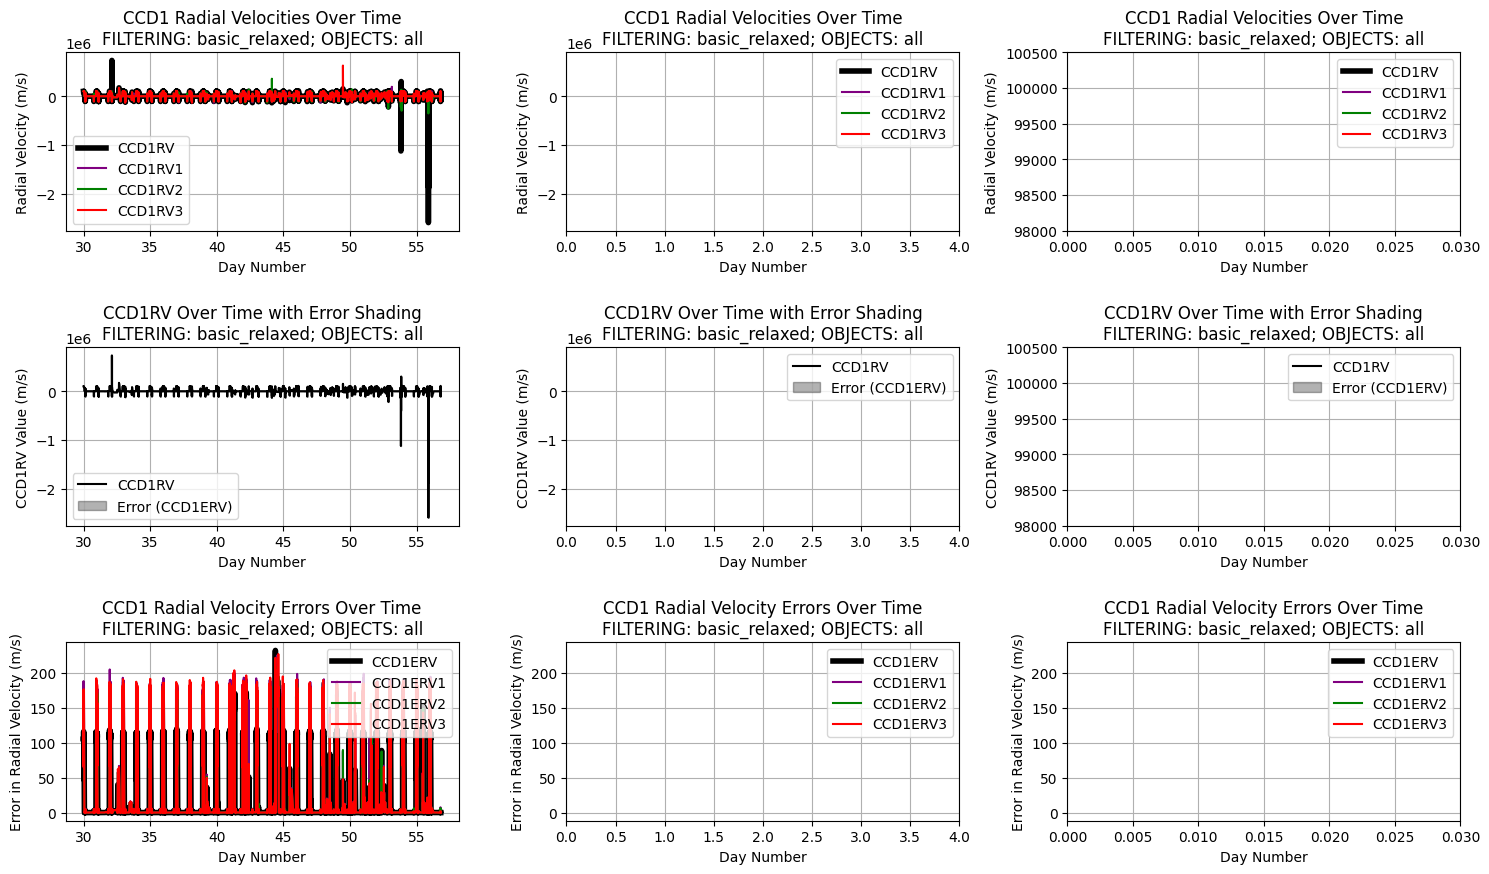

Radial Velocity Value (RV) Statistics:


Mean (m/s)  Median (m/s)  Mode (m/s)     IQR (m/s)   StDev (m/s)  \
CCD1RV   24867.703422     -6.143259         0.0  99772.719537  59892.040024   
CCD1RV1  25699.615599     -5.218691         0.0  99060.243027  49753.396215   
CCD1RV2  25508.594122     -4.793250         0.0  99257.422985  51118.859001   
CCD1RV3  25729.038994     -6.853349         0.0  98952.525681  50677.169692   

            CoV (%)  Skewness    Kurtosis  
CCD1RV   240.842667 -9.130887  369.289765  
CCD1RV1  193.595877  0.383327   -0.503393  
CCD1RV2  200.398575  0.241163    0.036367  
CCD1RV3  196.964876  0.443929    0.954386

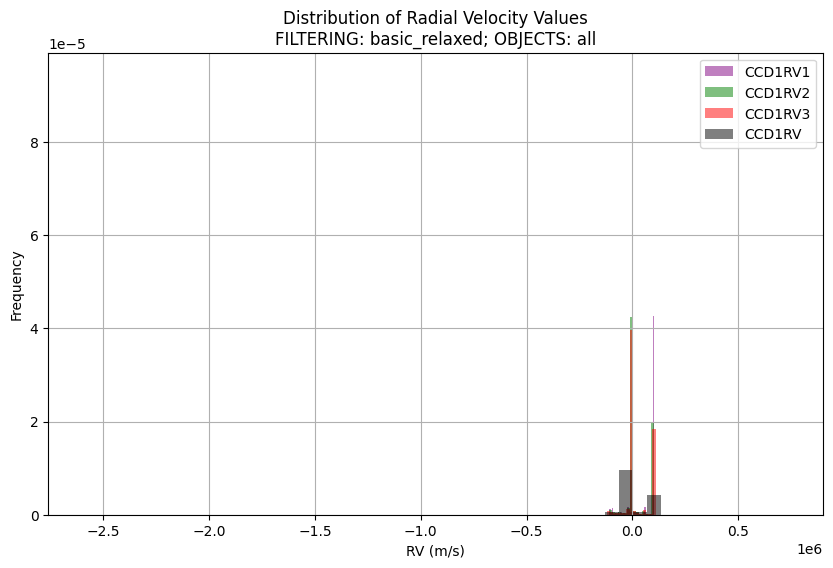

Radial Velocity Error (ERV) Statistics:


Mean (m/s)  Median (m/s)  Mode (m/s)   IQR (m/s)  StDev (m/s)  \
CCD1ERV    31.752793      0.234349         0.0  105.532361    49.524708   
CCD1ERV1   45.993518      0.425565         0.0  150.553460    72.865903   
CCD1ERV2   44.669499      0.380397         0.0  145.913600    69.890260   
CCD1ERV3   42.313464      0.415785         0.0   68.209400    68.915888   

             CoV (%)  Skewness  Kurtosis  
CCD1ERV   155.969614  0.974859 -0.984132  
CCD1ERV1  158.426459  1.043179 -0.846663  
CCD1ERV2  156.460811  0.989669 -0.979924  
CCD1ERV3  162.869878  1.181132 -0.462055

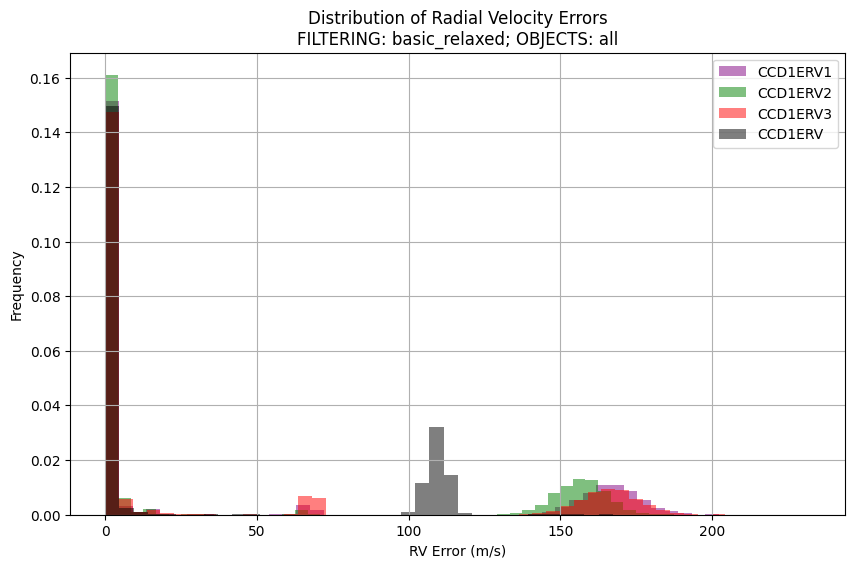

In [114]:
# pass all ccd1 data
df_ccd1 = df_ccd1
perform_standard_examination(df=df_ccd1, xmin=0, xmax=.03, ymin=98000, ymax=100500, subtitle='FILTERING: basic_relaxed; OBJECTS: all')

## EDA - CCD1 - Etalon

#### EDA - CCD1 - Etalon - all

In [115]:
# pass only objects that are etalon
df_ccd1_etalon= df_ccd1[df_ccd1['OBJECT'].str.contains('autocal-etalon')]

"""
num_postfilter_qc = len(df_ccd1_etalon)
# pass only data within the following SNR bands
df_ccd1_etalon = df_ccd1_etalon[
    #(df_ccd1_etalon['SNRSC452'] >= -22) & # these data are always junk (they're always negative) and can be ignored
    (df_ccd1_etalon['SNRSC548'] >= 500) &
    (df_ccd1_etalon['SNRSC548'] <= 1250) &
    (df_ccd1_etalon['SNRSC652'] >= 500) &
    (df_ccd1_etalon['SNRSC652'] <= 1250) &
    (df_ccd1_etalon['SNRSC747'] >= 500) &
    (df_ccd1_etalon['SNRSC747'] <= 1100) &
    (df_ccd1_etalon['SNRSC852'] >= 500) &
    (df_ccd1_etalon['SNRSC852'] <= 1025)
]
num_postfilter_snr = len(df_ccd1_etalon)
print(f"\nPercentage of observations kept after QC filtering:  {num_postfilter_snr/num_postfilter_qc}")
print(num_postfilter_snr)
"""

'\nnum_postfilter_qc = len(df_ccd1_etalon)\n# pass only data within the following SNR bands\ndf_ccd1_etalon = df_ccd1_etalon[\n    #(df_ccd1_etalon[\'SNRSC452\'] >= -22) & # these data are always junk (they\'re always negative) and can be ignored\n    (df_ccd1_etalon[\'SNRSC548\'] >= 500) &\n    (df_ccd1_etalon[\'SNRSC548\'] <= 1250) &\n    (df_ccd1_etalon[\'SNRSC652\'] >= 500) &\n    (df_ccd1_etalon[\'SNRSC652\'] <= 1250) &\n    (df_ccd1_etalon[\'SNRSC747\'] >= 500) &\n    (df_ccd1_etalon[\'SNRSC747\'] <= 1100) &\n    (df_ccd1_etalon[\'SNRSC852\'] >= 500) &\n    (df_ccd1_etalon[\'SNRSC852\'] <= 1025)\n]\nnum_postfilter_snr = len(df_ccd1_etalon)\nprint(f"\nPercentage of observations kept after QC filtering:  {num_postfilter_snr/num_postfilter_qc}")\nprint(num_postfilter_snr)\n'

DataFrame Shape: (2562, 185)
['autocal-etalon-all-eve' 'autocal-etalon-all-night'
 'autocal-etalon-all-morn' 'autocal-etalon-all-midday']


/tmp/ipykernel_31/1733266532.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_31/1733266532.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



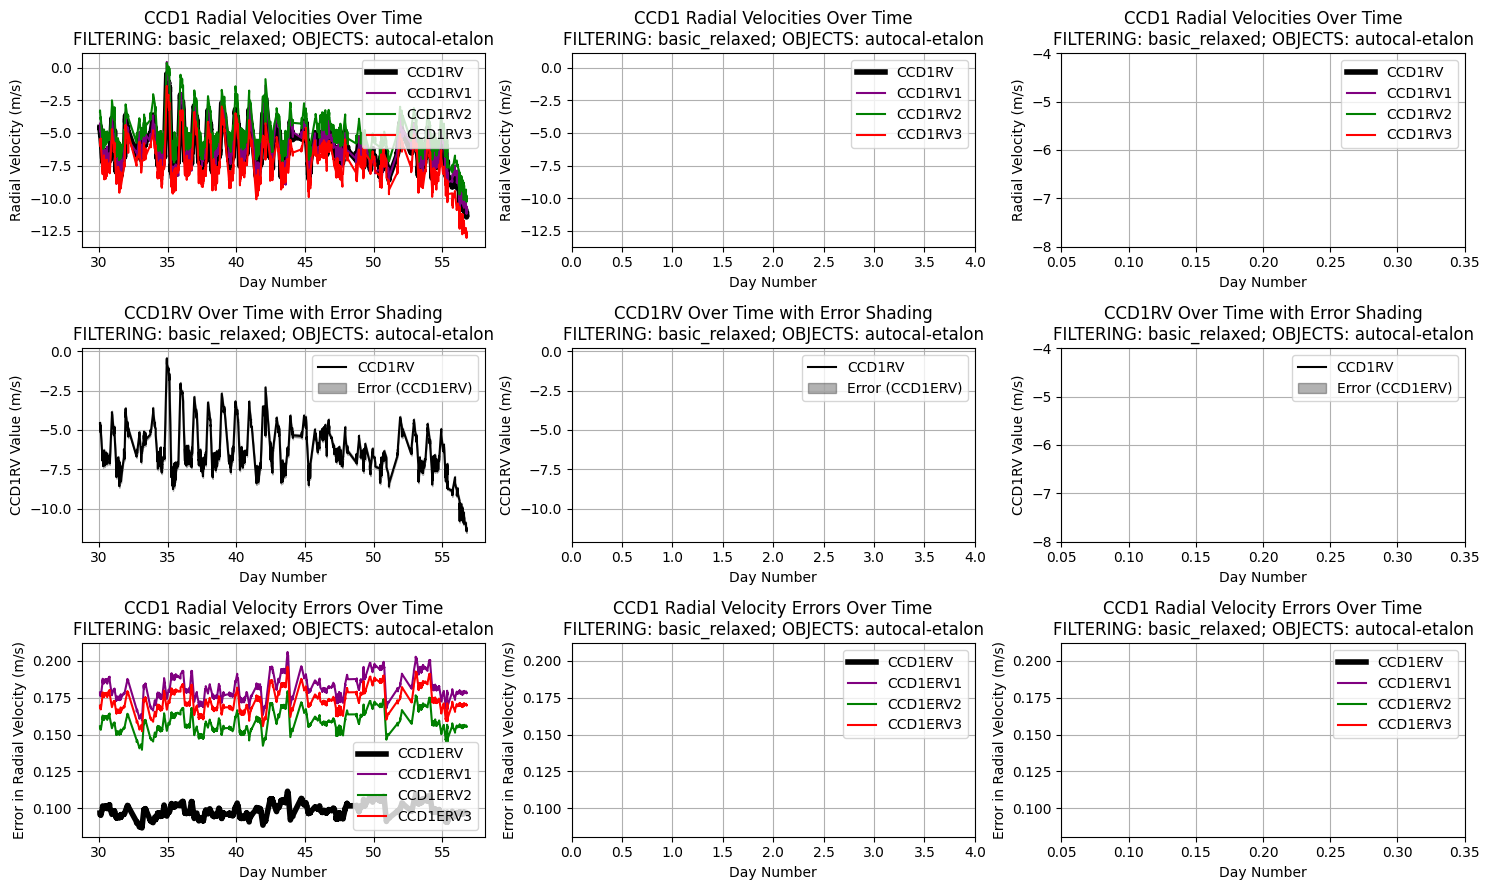

Radial Velocity Value (RV) Statistics:


Mean (m/s)  Median (m/s)  Mode (m/s)  IQR (m/s)  StDev (m/s)  \
CCD1RV    -6.982655     -7.009102  -11.454393   1.031366     1.283297   
CCD1RV1   -6.866597     -6.830375  -11.221960   1.445280     1.367399   
CCD1RV2   -5.675837     -5.724260  -10.291771   1.053385     1.258602   
CCD1RV3   -8.042637     -8.090688  -13.068031   1.137617     1.387767   

           CoV (%)  Skewness  Kurtosis  
CCD1RV  -18.378354  0.180554  3.170214  
CCD1RV1 -19.913777  0.371054  2.116501  
CCD1RV2 -22.174740  0.155130  3.345118  
CCD1RV3 -17.255118 -0.093490  2.918302

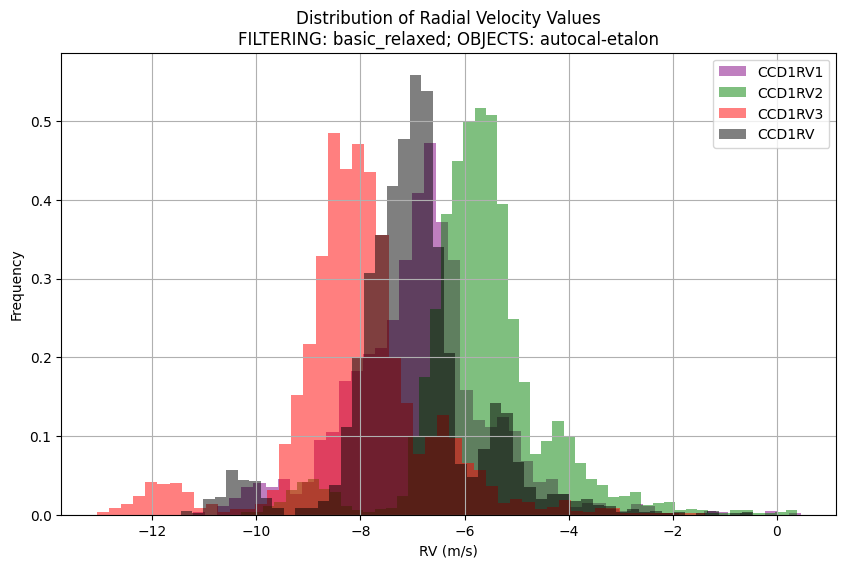

Radial Velocity Error (ERV) Statistics:


Mean (m/s)  Median (m/s)  Mode (m/s)  IQR (m/s)  StDev (m/s)  \
CCD1ERV     0.098240      0.097342    0.093457   0.006222     0.004275   
CCD1ERV1    0.181539      0.179830    0.174266   0.012216     0.007955   
CCD1ERV2    0.157995      0.156567    0.149399   0.009312     0.006880   
CCD1ERV3    0.172624      0.171052    0.162946   0.010930     0.007489   

           CoV (%)  Skewness  Kurtosis  
CCD1ERV   4.351709  0.401148 -0.606221  
CCD1ERV1  4.382234  0.381813 -0.653079  
CCD1ERV2  4.354869  0.434569 -0.567685  
CCD1ERV3  4.338144  0.385075 -0.600260

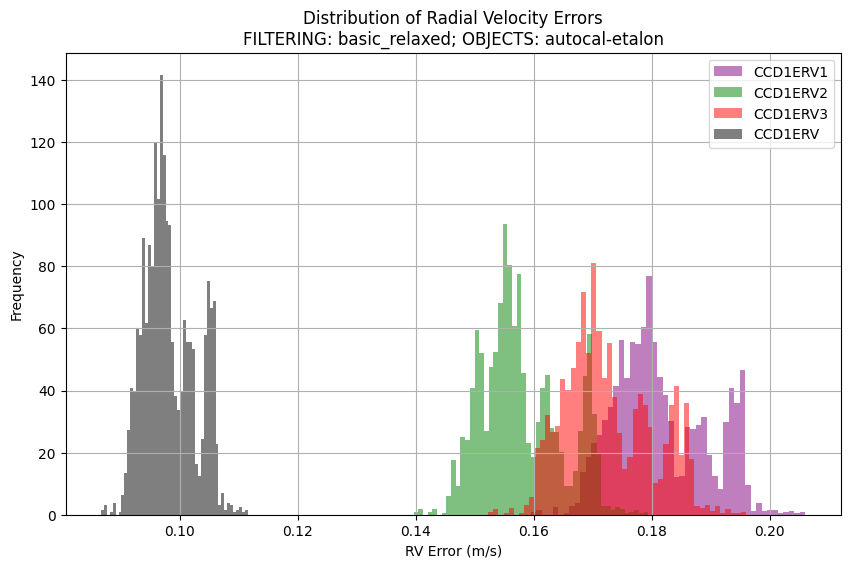

In [116]:
perform_standard_examination(df=df_ccd1_etalon, xmin=0.05, xmax=.35, ymin=-8, ymax=-4, subtitle='FILTERING: basic_relaxed; OBJECTS: autocal-etalon')

#### EDA - CCD1 - Etalon - Eve

DataFrame Shape: (162, 185)
['autocal-etalon-all-eve']


/tmp/ipykernel_31/1733266532.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_31/1733266532.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



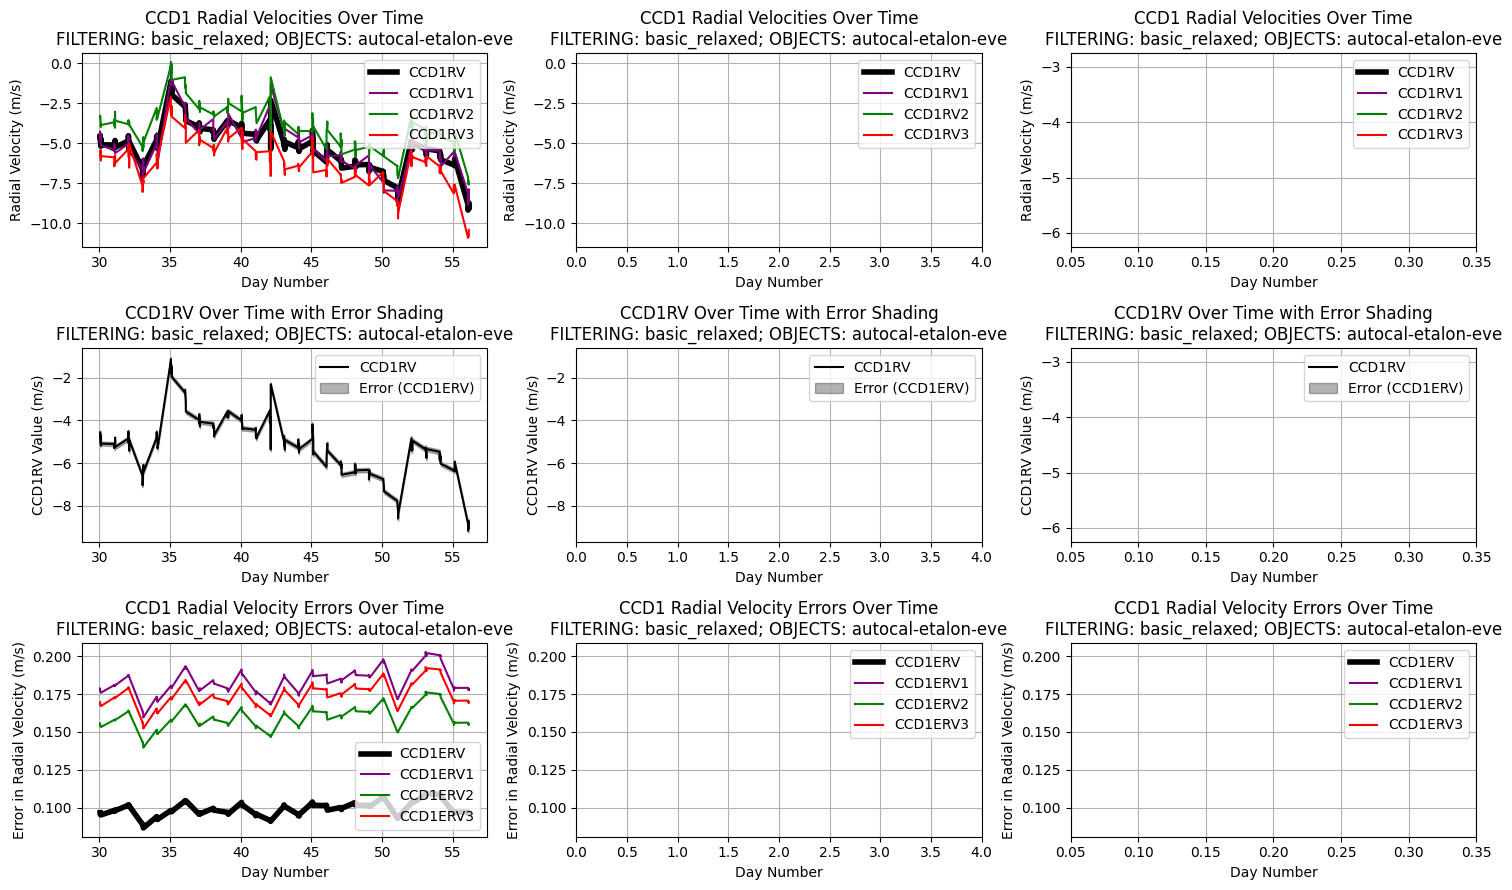

Radial Velocity Value (RV) Statistics:


Mean (m/s)  Median (m/s)  Mode (m/s)  IQR (m/s)  StDev (m/s)  \
CCD1RV    -5.262563     -5.170713   -9.183608   1.747154     1.528653   
CCD1RV1   -5.182757     -5.147432   -8.861428   1.754253     1.649266   
CCD1RV2   -3.986027     -3.906546   -7.585995   1.856362     1.528688   
CCD1RV3   -6.244099     -6.204890  -10.926395   1.560695     1.594506   

           CoV (%)  Skewness  Kurtosis  
CCD1RV  -29.047687 -0.063115  0.852020  
CCD1RV1 -31.822177  0.190167  0.737390  
CCD1RV2 -38.351165  0.044287  0.425625  
CCD1RV3 -25.536198 -0.425666  1.224710

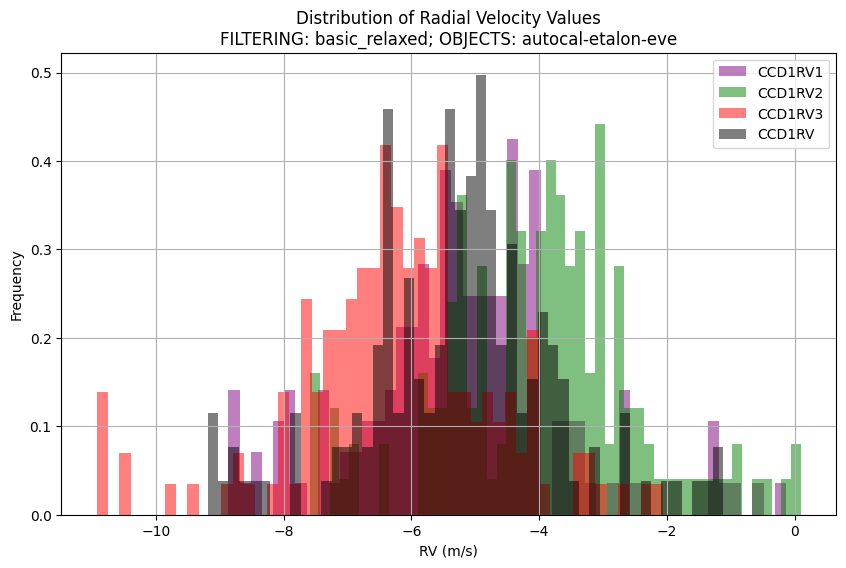

Radial Velocity Error (ERV) Statistics:


Mean (m/s)  Median (m/s)  Mode (m/s)  IQR (m/s)  StDev (m/s)  \
CCD1ERV     0.099064      0.098337    0.086617   0.006250     0.005013   
CCD1ERV1    0.182820      0.181924    0.159545   0.011283     0.009328   
CCD1ERV2    0.159416      0.158140    0.176634   0.010167     0.008010   
CCD1ERV3    0.174191      0.172924    0.152264   0.011279     0.008823   

           CoV (%)  Skewness  Kurtosis  
CCD1ERV   5.060354  0.055688 -0.259068  
CCD1ERV1  5.102232  0.040141 -0.243438  
CCD1ERV2  5.024849  0.067464 -0.262420  
CCD1ERV3  5.065276  0.055495 -0.280914

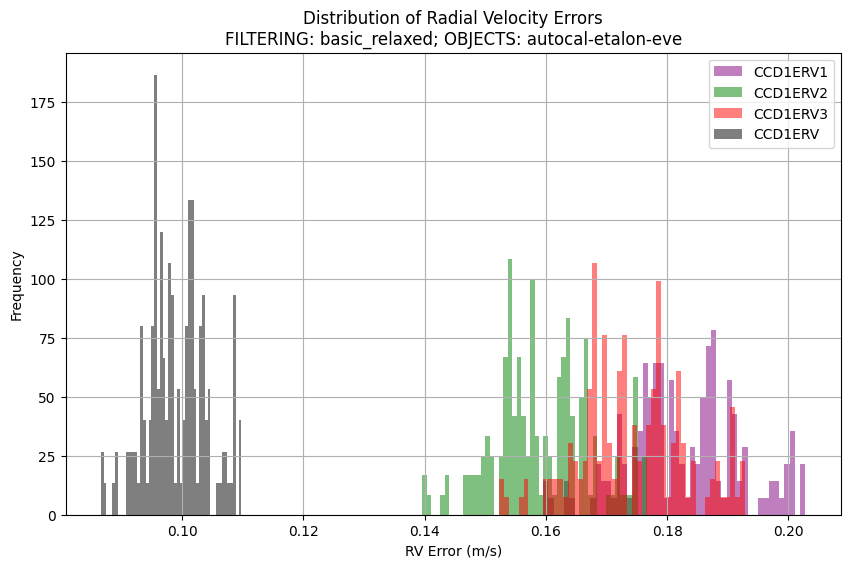

In [117]:
# pass only objects that are etalon - eve
df_ccd1_etalon_eve = df_ccd1_etalon[df_ccd1_etalon['OBJECT'] == 'autocal-etalon-all-eve']
perform_standard_examination(df=df_ccd1_etalon_eve, xmin=0.05, xmax=.35, ymin=-6.25, ymax=-2.75, subtitle='FILTERING: basic_relaxed; OBJECTS: autocal-etalon-eve')

#### EDA - CCD1 - Etalon - Night

DataFrame Shape: (2160, 185)
['autocal-etalon-all-night']


/tmp/ipykernel_31/1733266532.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_31/1733266532.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



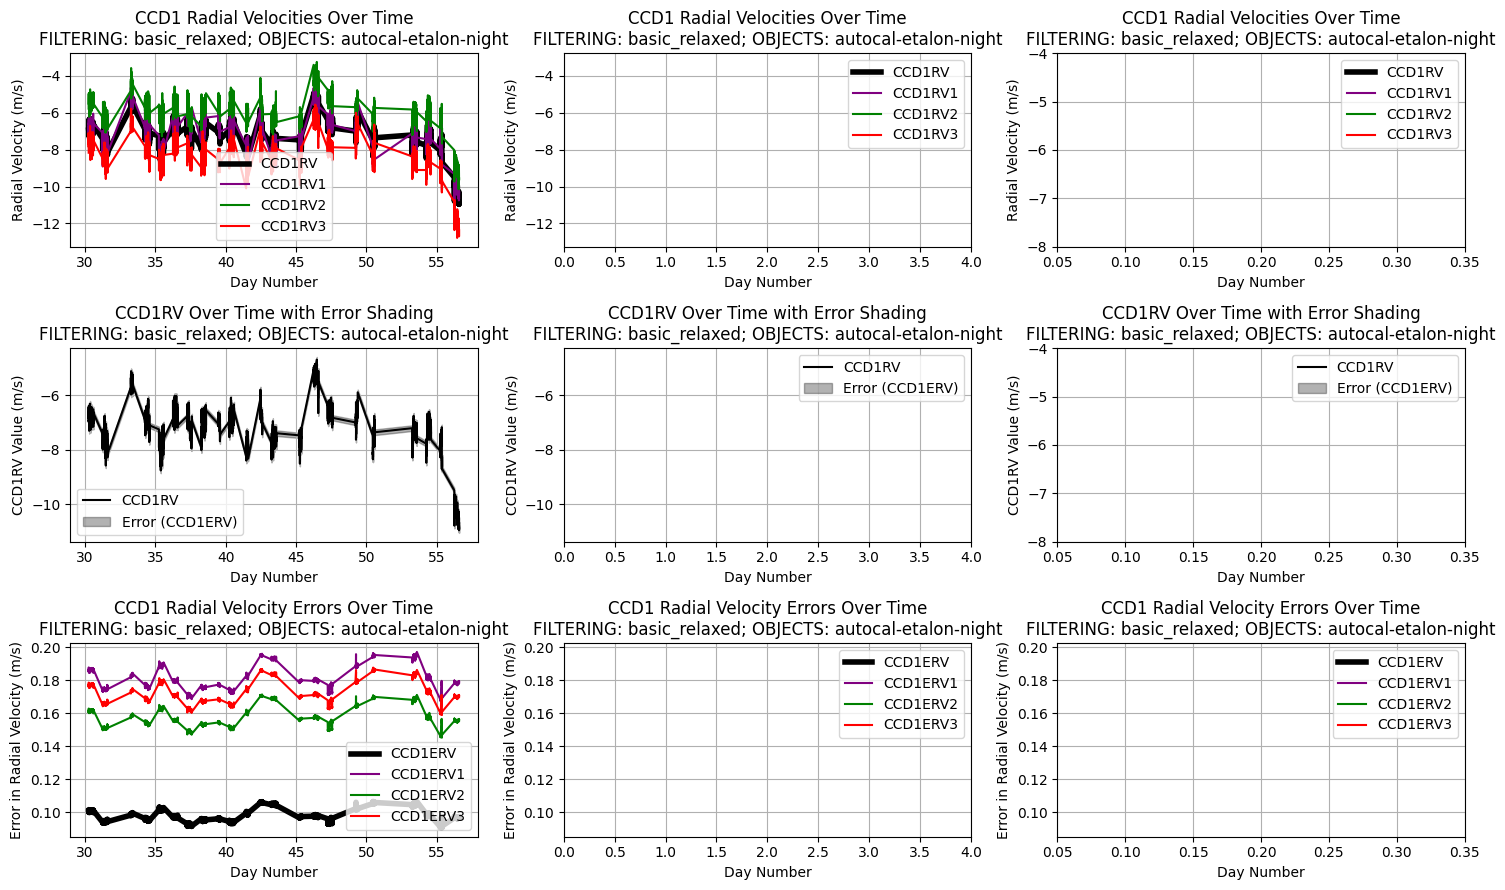

Radial Velocity Value (RV) Statistics:


Mean (m/s)  Median (m/s)  Mode (m/s)  IQR (m/s)  StDev (m/s)  \
CCD1RV    -7.221716     -7.123122  -10.965527   0.957239     1.031067   
CCD1RV1   -7.097561     -6.929916  -10.753442   1.391294     1.139610   
CCD1RV2   -5.908897     -5.832210  -10.148496   0.915301     1.004731   
CCD1RV3   -8.297298     -8.226939  -12.786357   0.983781     1.139284   

           CoV (%)  Skewness  Kurtosis  
CCD1RV  -14.277310 -1.050961  2.756033  
CCD1RV1 -16.056360 -0.503989  0.416184  
CCD1RV2 -17.003700 -1.192738  3.117768  
CCD1RV3 -13.730783 -1.206884  3.154356

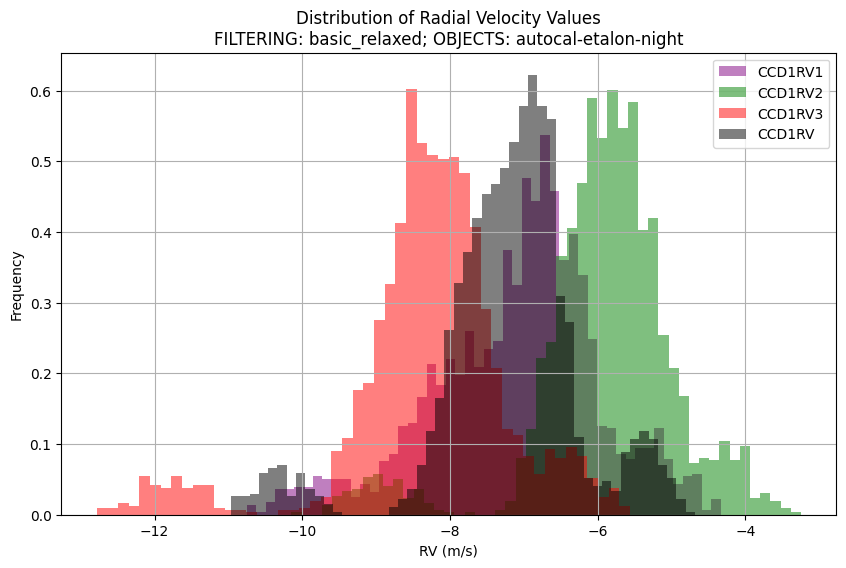

Radial Velocity Error (ERV) Statistics:


Mean (m/s)  Median (m/s)  Mode (m/s)  IQR (m/s)  StDev (m/s)  \
CCD1ERV     0.098100      0.097191    0.094133   0.006057     0.004093   
CCD1ERV1    0.181317      0.179562    0.174266   0.011888     0.007627   
CCD1ERV2    0.157757      0.156270    0.149399   0.009172     0.006596   
CCD1ERV3    0.172361      0.170709    0.162946   0.010755     0.007156   

           CoV (%)  Skewness  Kurtosis  
CCD1ERV   4.172267  0.463268 -0.811555  
CCD1ERV1  4.206326  0.452271 -0.878041  
CCD1ERV2  4.180801  0.499559 -0.741306  
CCD1ERV3  4.151522  0.436556 -0.813112

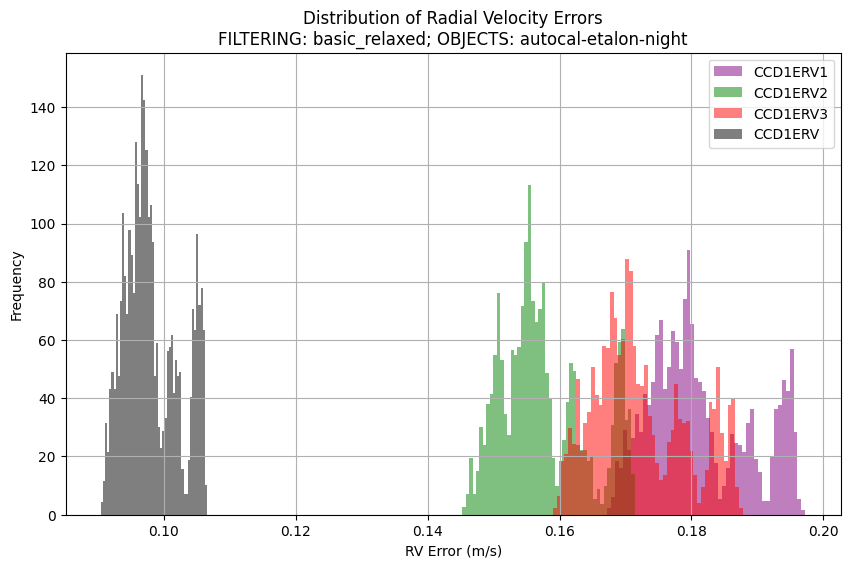

In [118]:
# pass only objects that are etalon - night
df_ccd1_etalon_night = df_ccd1_etalon[df_ccd1_etalon['OBJECT'].str.contains('autocal-etalon-all-night')]
perform_standard_examination(df=df_ccd1_etalon_night, xmin=0.05, xmax=.35, ymin=-8, ymax=-4, subtitle='FILTERING: basic_relaxed; OBJECTS: autocal-etalon-night')

#### EDA - CCD1 - Etalon - Morn

DataFrame Shape: (225, 185)
['autocal-etalon-all-morn']


/tmp/ipykernel_31/1733266532.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_31/1733266532.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



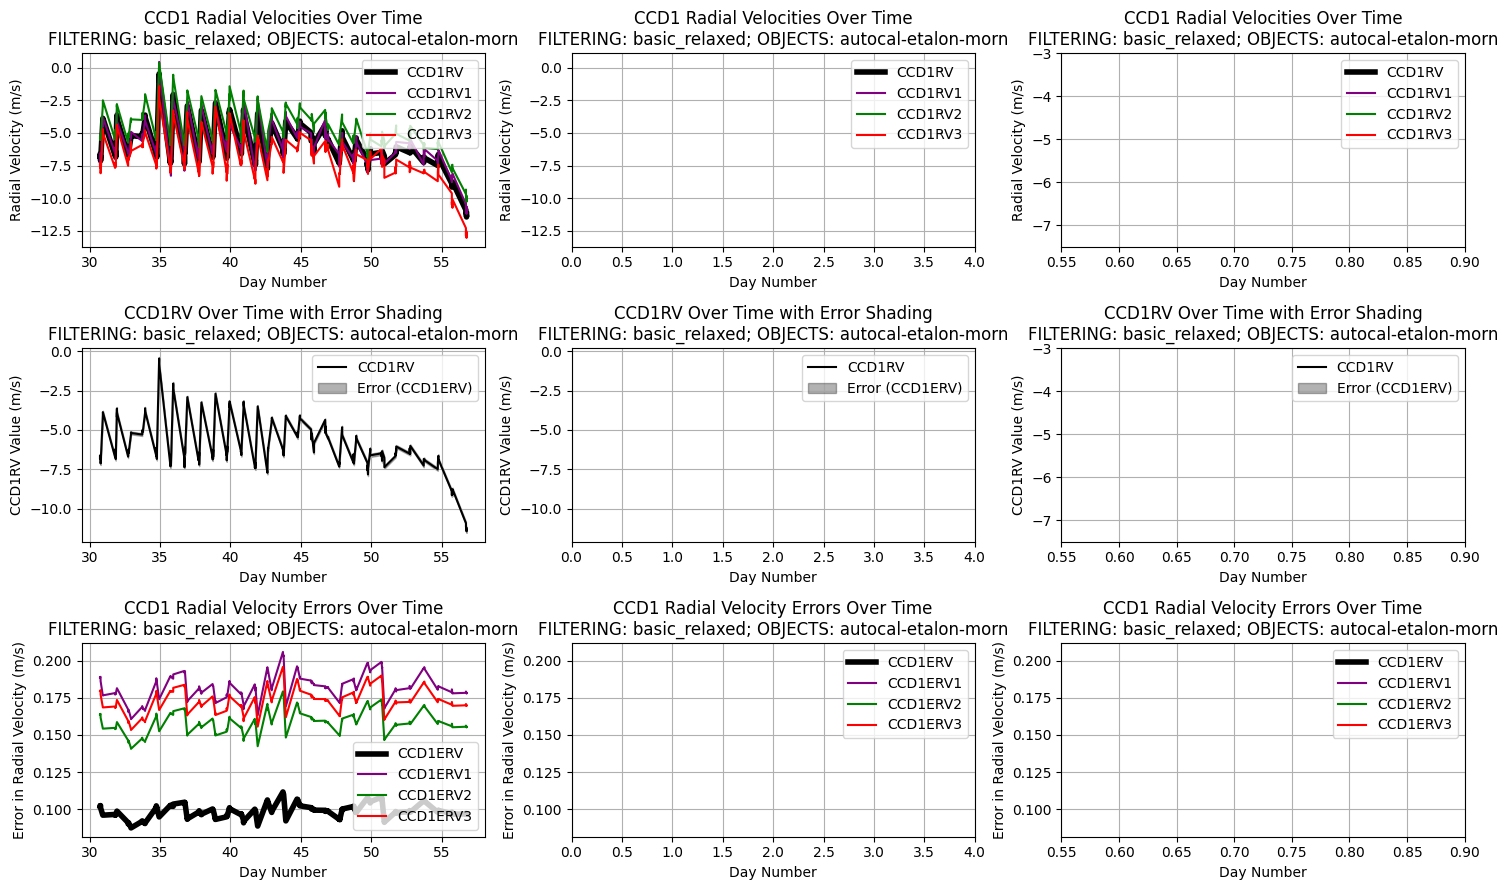

Radial Velocity Value (RV) Statistics:


Mean (m/s)  Median (m/s)  Mode (m/s)  IQR (m/s)  StDev (m/s)  \
CCD1RV    -6.030642     -6.395181  -11.454393   1.733225     1.730178   
CCD1RV1   -5.966036     -6.297449  -11.221960   1.776701     1.798038   
CCD1RV2   -4.763806     -5.150753  -10.291771   1.700873     1.718864   
CCD1RV3   -6.995411     -7.288709  -13.068031   1.871654     1.810528   

           CoV (%)  Skewness  Kurtosis  
CCD1RV  -28.689779  0.134063  1.812352  
CCD1RV1 -30.137903  0.473853  1.537173  
CCD1RV2 -36.081733  0.092106  1.616491  
CCD1RV3 -25.881661 -0.160386  2.047192

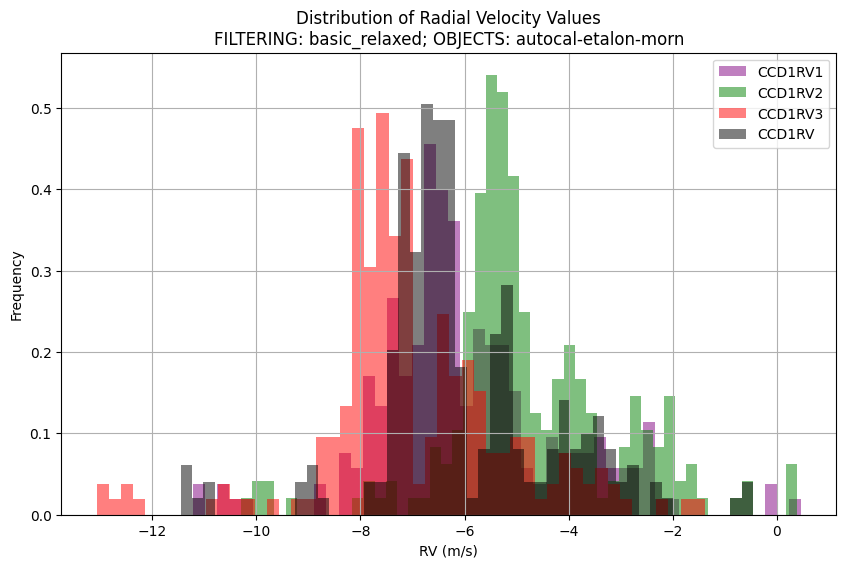

Radial Velocity Error (ERV) Statistics:


Mean (m/s)  Median (m/s)  Mode (m/s)  IQR (m/s)  StDev (m/s)  \
CCD1ERV     0.098908      0.098650    0.087239   0.006190     0.005163   
CCD1ERV1    0.182617      0.182115    0.160677   0.011209     0.009591   
CCD1ERV2    0.159129      0.158725    0.140642   0.009884     0.008262   
CCD1ERV3    0.173882      0.173432    0.153368   0.010823     0.009090   

           CoV (%)  Skewness  Kurtosis  
CCD1ERV   5.219887  0.076596 -0.330588  
CCD1ERV1  5.252072  0.048401 -0.306518  
CCD1ERV2  5.191738  0.098700 -0.335447  
CCD1ERV3  5.227879  0.080237 -0.348864

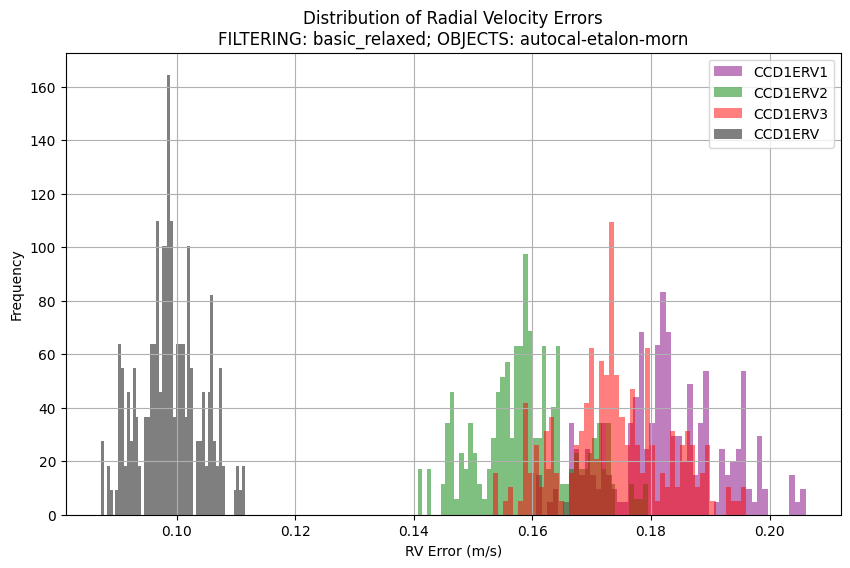

In [119]:
# pass only objects that are etalon - morn
df_ccd1_etalon_morn = df_ccd1_etalon[df_ccd1_etalon['OBJECT'].str.contains('autocal-etalon-all-morn')]
perform_standard_examination(df=df_ccd1_etalon_morn, xmin=0.55, xmax=.9, ymin=-7.5, ymax=-3, subtitle='FILTERING: basic_relaxed; OBJECTS: autocal-etalon-morn')

#### EDA - CCD1 - Etalon - Midday

DataFrame Shape: (15, 185)
['autocal-etalon-all-midday']


/tmp/ipykernel_31/1733266532.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_31/1733266532.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



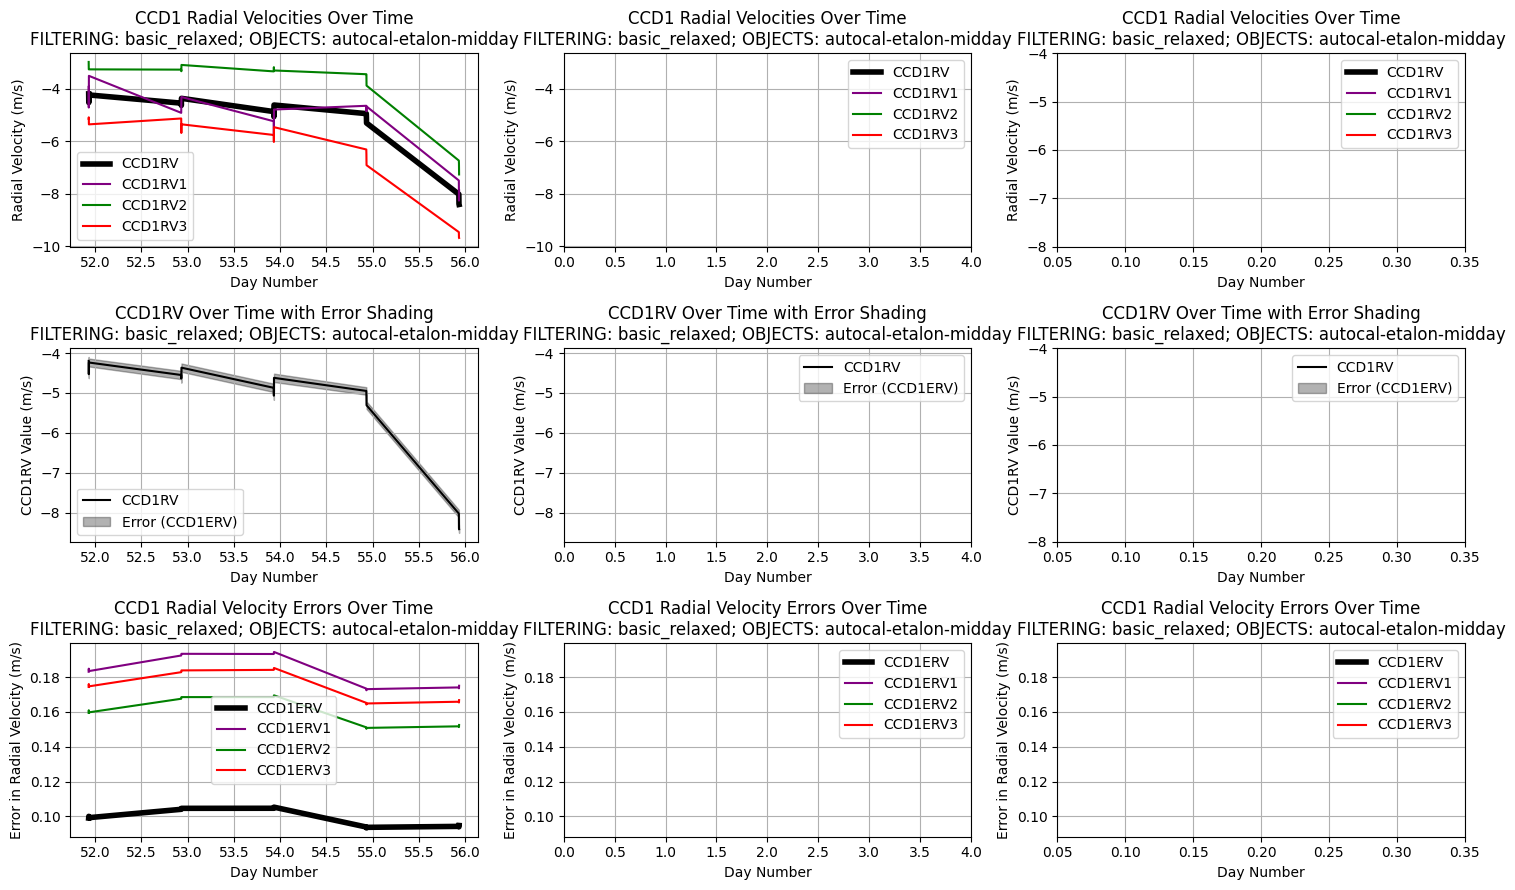

Radial Velocity Value (RV) Statistics:


Mean (m/s)  Median (m/s)  Mode (m/s)  IQR (m/s)  StDev (m/s)  \
CCD1RV    -5.415013     -4.871126   -8.406918   0.653928     1.512905   
CCD1RV1   -5.301724     -4.793213   -8.260159   0.883150     1.432347   
CCD1RV2   -4.045593     -3.335036   -7.264055   0.402576     1.520691   
CCD1RV3   -6.504094     -5.761658   -9.680298   1.351183     1.688818   

           CoV (%)  Skewness  Kurtosis  
CCD1RV  -27.939080 -1.353445  0.087196  
CCD1RV1 -27.016620 -1.076282 -0.110106  
CCD1RV2 -37.588832 -1.458150  0.246974  
CCD1RV3 -25.965453 -1.174674 -0.225736

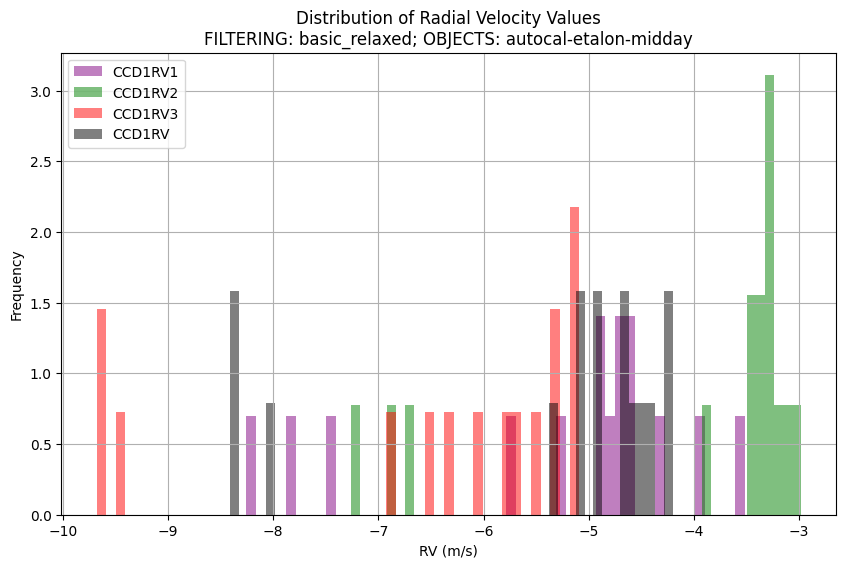

Radial Velocity Error (ERV) Statistics:


Mean (m/s)  Median (m/s)  Mode (m/s)  IQR (m/s)  StDev (m/s)  \
CCD1ERV     0.099426      0.099315    0.093427   0.010430     0.004979   
CCD1ERV1    0.183545      0.183413    0.172408   0.019404     0.009229   
CCD1ERV2    0.159964      0.159735    0.150304   0.016865     0.008044   
CCD1ERV3    0.174779      0.174647    0.164261   0.018081     0.008698   

           CoV (%)  Skewness  Kurtosis  
CCD1ERV   5.008051 -0.012110 -1.723159  
CCD1ERV1  5.028050 -0.019819 -1.726655  
CCD1ERV2  5.028470 -0.006959 -1.723865  
CCD1ERV3  4.976522 -0.015750 -1.718147

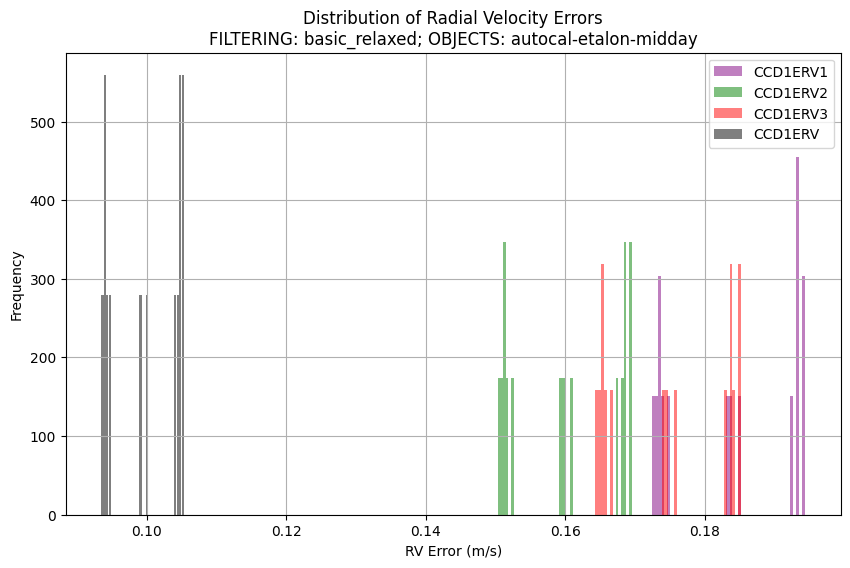

In [120]:
# pass only objects that are etalon - midday
df_ccd1_etalon_midday = df_ccd1_etalon[df_ccd1_etalon['OBJECT'].str.contains('autocal-etalon-all-midday')]
perform_standard_examination(df=df_ccd1_etalon_midday, xmin=0.05, xmax=.35, ymin=-8, ymax=-4, subtitle='FILTERING: basic_relaxed; OBJECTS: autocal-etalon-midday')

## EDA - CCD1 - LFC

#### EDA - CCD1 - LFC - all

In [121]:
# pass only objects that are lfc
df_ccd1_lfc = df_ccd1[df_ccd1['OBJECT'].str.contains('autocal-lfc')]

"""
num_postfilter_qc = len(df_ccd1_lfc)
# pass only data within the following SNR bands
df_ccd1_lfc = df_ccd1_lfc[
    #(df_ccd1_lfc['SNRSC452'] >= -22) & # these data are always junk (they're always negative) and can be ignored
    (df_ccd1_lfc['SNRSC548'] >= 500) &
    (df_ccd1_lfc['SNRSC548'] <= 1250) &
    (df_ccd1_lfc['SNRSC652'] >= 500) &
    (df_ccd1_lfc['SNRSC652'] <= 1250) &
    (df_ccd1_lfc['SNRSC747'] >= 500) &
    (df_ccd1_lfc['SNRSC747'] <= 1100) &
    (df_ccd1_lfc['SNRSC852'] >= 500) &
    (df_ccd1_lfc['SNRSC852'] <= 1025)
]
num_postfilter_snr = len(df_ccd1_lfc)
print(f"\nPercentage of observations kept after QC filtering:  {num_postfilter_snr/num_postfilter_qc}")
print(num_postfilter_snr)
"""

'\nnum_postfilter_qc = len(df_ccd1_lfc)\n# pass only data within the following SNR bands\ndf_ccd1_lfc = df_ccd1_lfc[\n    #(df_ccd1_lfc[\'SNRSC452\'] >= -22) & # these data are always junk (they\'re always negative) and can be ignored\n    (df_ccd1_lfc[\'SNRSC548\'] >= 500) &\n    (df_ccd1_lfc[\'SNRSC548\'] <= 1250) &\n    (df_ccd1_lfc[\'SNRSC652\'] >= 500) &\n    (df_ccd1_lfc[\'SNRSC652\'] <= 1250) &\n    (df_ccd1_lfc[\'SNRSC747\'] >= 500) &\n    (df_ccd1_lfc[\'SNRSC747\'] <= 1100) &\n    (df_ccd1_lfc[\'SNRSC852\'] >= 500) &\n    (df_ccd1_lfc[\'SNRSC852\'] <= 1025)\n]\nnum_postfilter_snr = len(df_ccd1_lfc)\nprint(f"\nPercentage of observations kept after QC filtering:  {num_postfilter_snr/num_postfilter_qc}")\nprint(num_postfilter_snr)\n'

DataFrame Shape: (578, 185)
['autocal-lfc-all-eve' 'autocal-lfc-all-midnight' 'autocal-lfc-all-morn']


/tmp/ipykernel_31/1733266532.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_31/1733266532.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



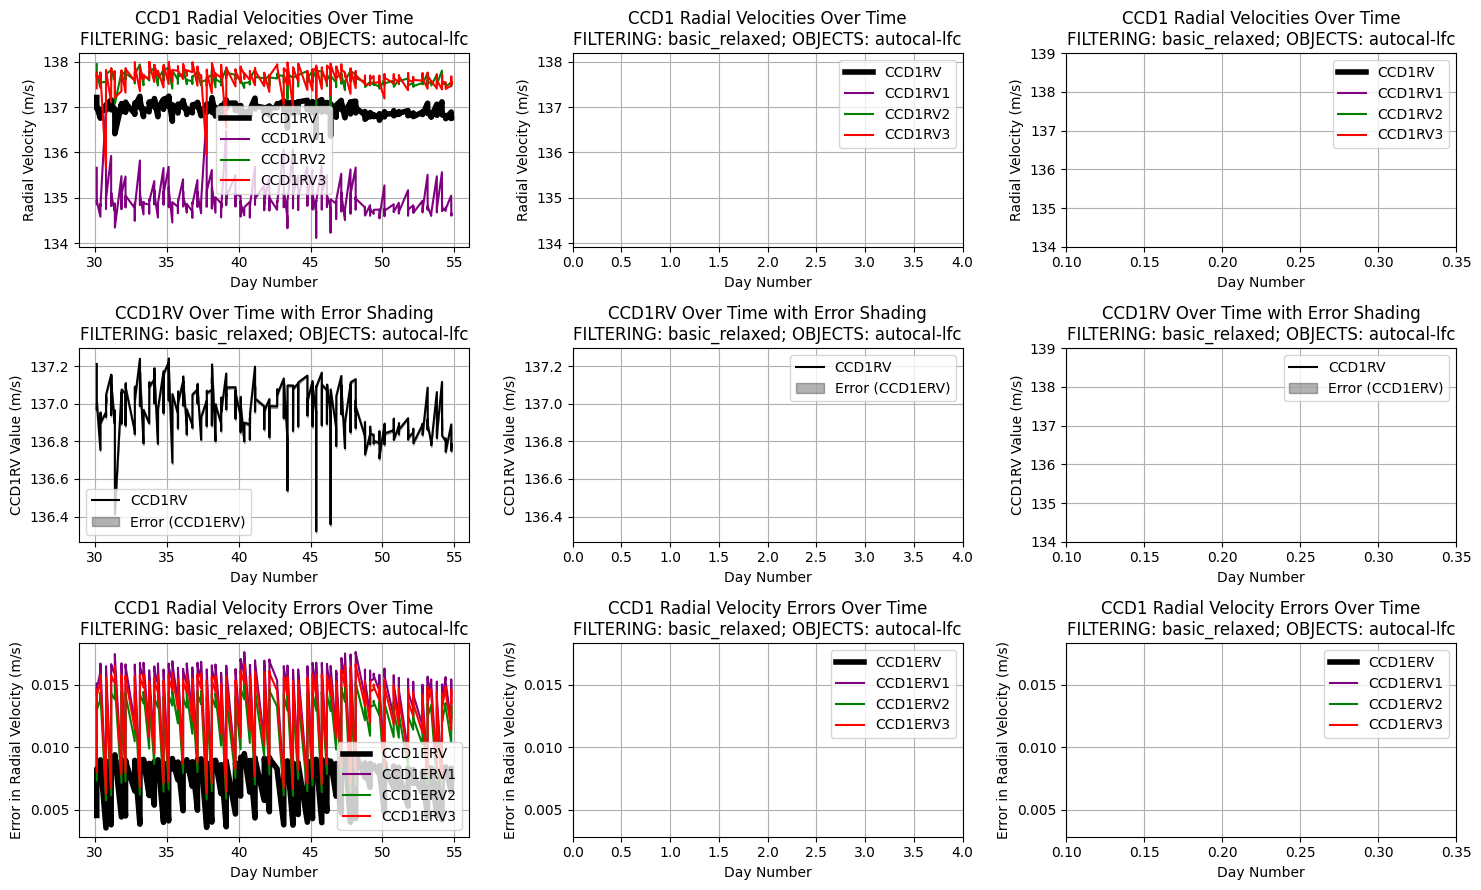

Radial Velocity Value (RV) Statistics:


Mean (m/s)  Median (m/s)  Mode (m/s)  IQR (m/s)  StDev (m/s)  \
CCD1RV   136.961339    136.966874  136.322339   0.185112     0.120015   
CCD1RV1  134.901046    134.862933  134.115105   0.262064     0.266269   
CCD1RV2  137.621856    137.613330  136.962296   0.169435     0.117531   
CCD1RV3  137.728151    137.750701  135.649815   0.176824     0.192729   

          CoV (%)  Skewness   Kurtosis  
CCD1RV   0.087627 -0.594815   2.114584  
CCD1RV1  0.197381  2.769958  15.158610  
CCD1RV2  0.085401 -0.479025   2.724034  
CCD1RV3  0.139934 -4.379412  37.250691

Radial Velocity Error (ERV) Statistics:


Mean (m/s)  Median (m/s)  Mode (m/s)  IQR (m/s)  StDev (m/s)  \
CCD1ERV     0.008387      0.008730    0.008923   0.000632     0.001111   
CCD1ERV1    0.015529      0.016179    0.015436   0.001192     0.002098   
CCD1ERV2    0.013423      0.013962    0.012870   0.000978     0.001758   
CCD1ERV3    0.014705      0.015299    0.014659   0.001089     0.001931   

            CoV (%)  Skewness  Kurtosis  
CCD1ERV   13.243521 -2.836873  7.859542  
CCD1ERV1  13.507750 -2.804825  7.678303  
CCD1ERV2  13.094330 -2.861901  7.992963  
CCD1ERV3  13.130240 -2.852158  7.944105

In [122]:

perform_standard_examination(df=df_ccd1_lfc, xmin=0.1, xmax=.35, ymin=134, ymax=139, subtitle='FILTERING: basic_relaxed; OBJECTS: autocal-lfc')

#### EDA - CCD1 - LFC - eve

DataFrame Shape: (250, 185)
['autocal-lfc-all-eve']


/tmp/ipykernel_31/1733266532.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_31/1733266532.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



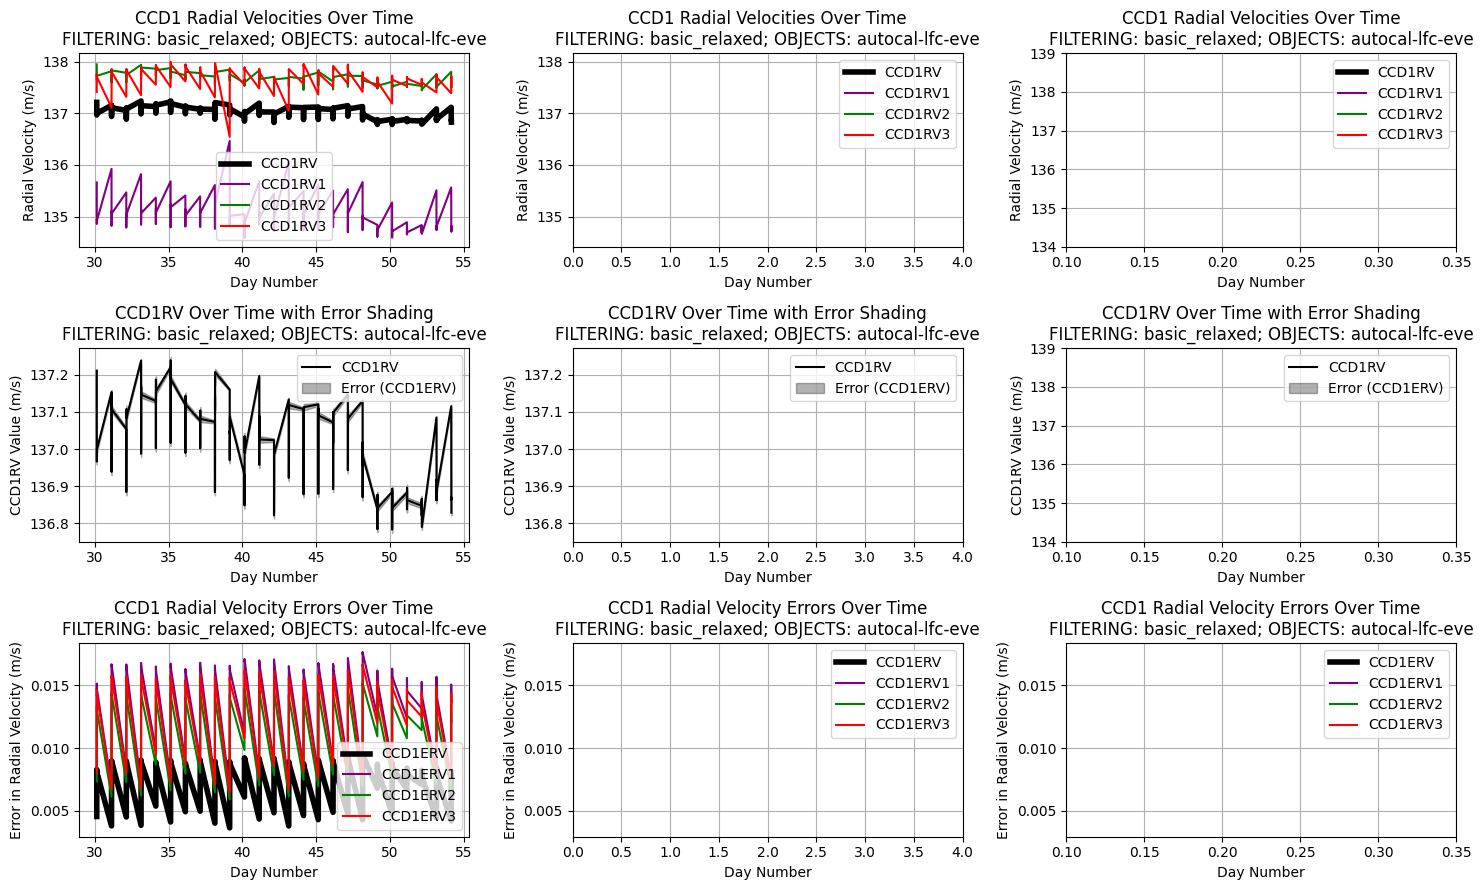

Radial Velocity Value (RV) Statistics:


Mean (m/s)  Median (m/s)  Mode (m/s)  IQR (m/s)  StDev (m/s)  \
CCD1RV   137.000793    137.000668  136.782814   0.186249     0.109199   
CCD1RV1  134.972368    134.942311  134.585615   0.264081     0.254202   
CCD1RV2  137.659436    137.660820  137.443770   0.176129     0.112295   
CCD1RV3  137.739083    137.770842  136.542969   0.174376     0.166620   

          CoV (%)  Skewness   Kurtosis  
CCD1RV   0.079707  0.018634  -0.994335  
CCD1RV1  0.188336  2.038349   6.642002  
CCD1RV2  0.081575  0.198590  -0.853265  
CCD1RV3  0.120968 -2.415255  11.646050

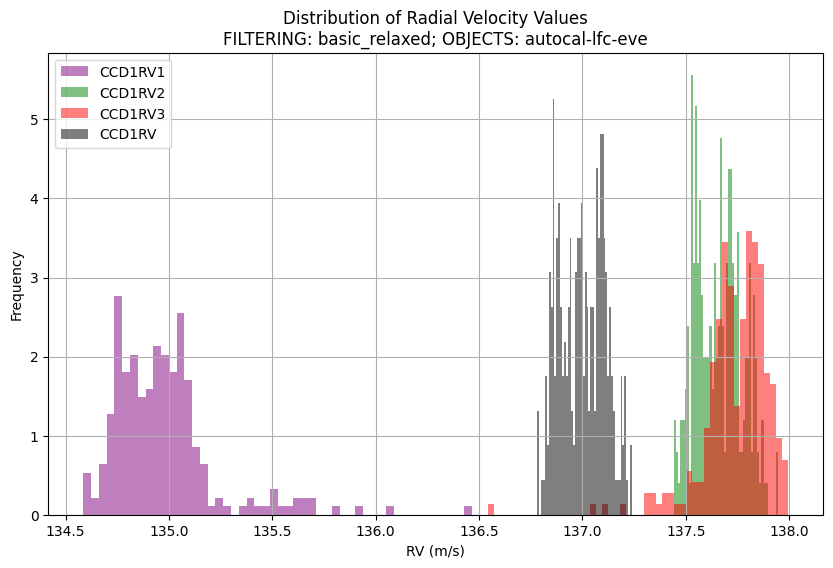

Radial Velocity Error (ERV) Statistics:


Mean (m/s)  Median (m/s)  Mode (m/s)  IQR (m/s)  StDev (m/s)  \
CCD1ERV     0.008340      0.008788    0.008923   0.000689     0.001278   
CCD1ERV1    0.015437      0.016294    0.006648   0.001343     0.002412   
CCD1ERV2    0.013348      0.014053    0.014128   0.001074     0.002023   
CCD1ERV3    0.014626      0.015401    0.015369   0.001199     0.002223   

            CoV (%)  Skewness  Kurtosis  
CCD1ERV   15.325856 -2.454561  5.051624  
CCD1ERV1  15.624837 -2.427092  4.928826  
CCD1ERV2  15.158336 -2.475182  5.139228  
CCD1ERV3  15.199625 -2.466560  5.104656

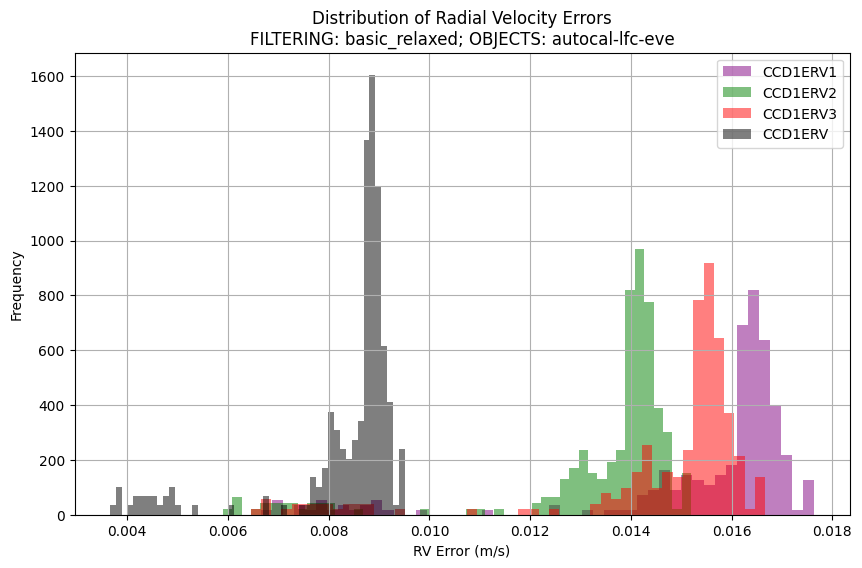

In [123]:
# pass only objects that are lfc - even
df_ccd1_lfc_eve = df_ccd1_lfc[df_ccd1_lfc['OBJECT'] == 'autocal-lfc-all-eve']
perform_standard_examination(df=df_ccd1_lfc_eve, xmin=0.1, xmax=.35, ymin=134, ymax=139, subtitle='FILTERING: basic_relaxed; OBJECTS: autocal-lfc-eve')

#### EDA - CCD1 - LFC - midnight

DataFrame Shape: (79, 185)
['autocal-lfc-all-midnight']


/tmp/ipykernel_31/1733266532.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_31/1733266532.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



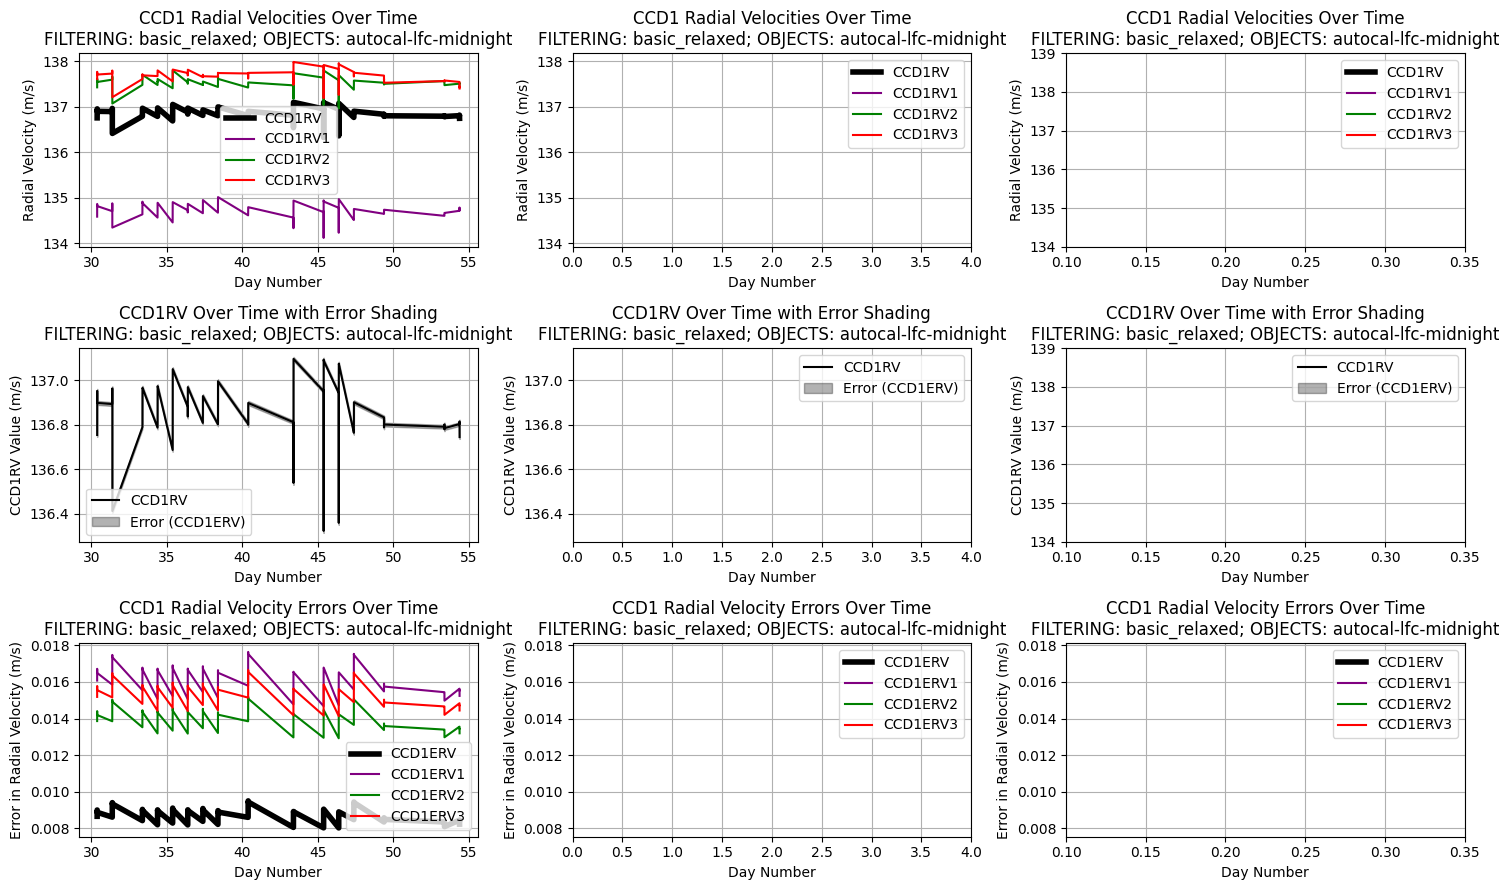

Radial Velocity Value (RV) Statistics:


Mean (m/s)  Median (m/s)  Mode (m/s)  IQR (m/s)  StDev (m/s)  \
CCD1RV   136.860170    136.865337  136.322339   0.149188     0.140331   
CCD1RV1  134.731205    134.751851  134.115105   0.191561     0.160415   
CCD1RV2  137.530309    137.533052  136.962296   0.120919     0.143282   
CCD1RV3  137.683771    137.700552  137.186465   0.144130     0.152475   

          CoV (%)  Skewness  Kurtosis  
CCD1RV   0.102536 -1.550207  4.262210  
CCD1RV1  0.119063 -1.310917  2.764860  
CCD1RV2  0.104182 -1.540447  4.710699  
CCD1RV3  0.110743 -0.910225  1.836127

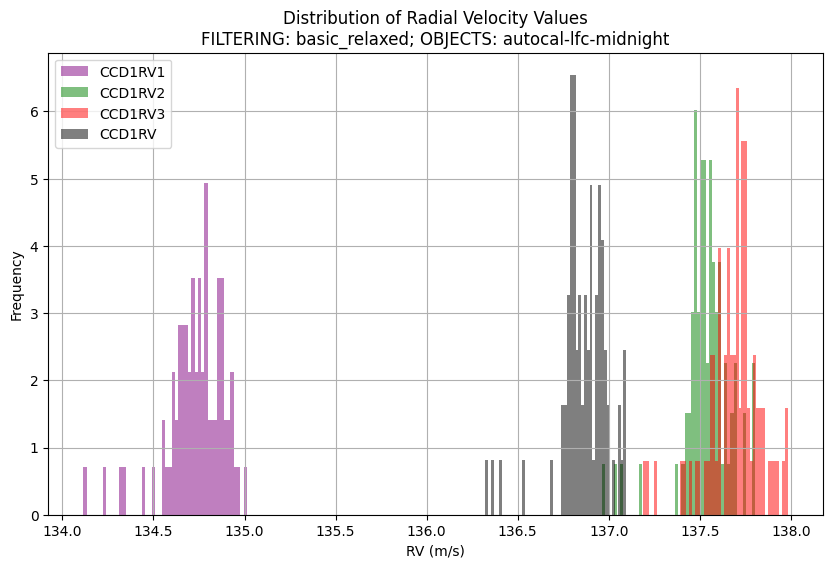

Radial Velocity Error (ERV) Statistics:


Mean (m/s)  Median (m/s)  Mode (m/s)  IQR (m/s)  StDev (m/s)  \
CCD1ERV     0.008804      0.008921    0.008938   0.000537     0.000384   
CCD1ERV1    0.016305      0.016541    0.015436   0.001052     0.000754   
CCD1ERV2    0.014091      0.014262    0.013395   0.000814     0.000590   
CCD1ERV3    0.015431      0.015627    0.014659   0.000925     0.000654   

           CoV (%)  Skewness  Kurtosis  
CCD1ERV   4.357264 -0.267255 -0.752509  
CCD1ERV1  4.622695 -0.343753 -0.700744  
CCD1ERV2  4.183530 -0.223827 -0.750495  
CCD1ERV3  4.239645 -0.238266 -0.771372

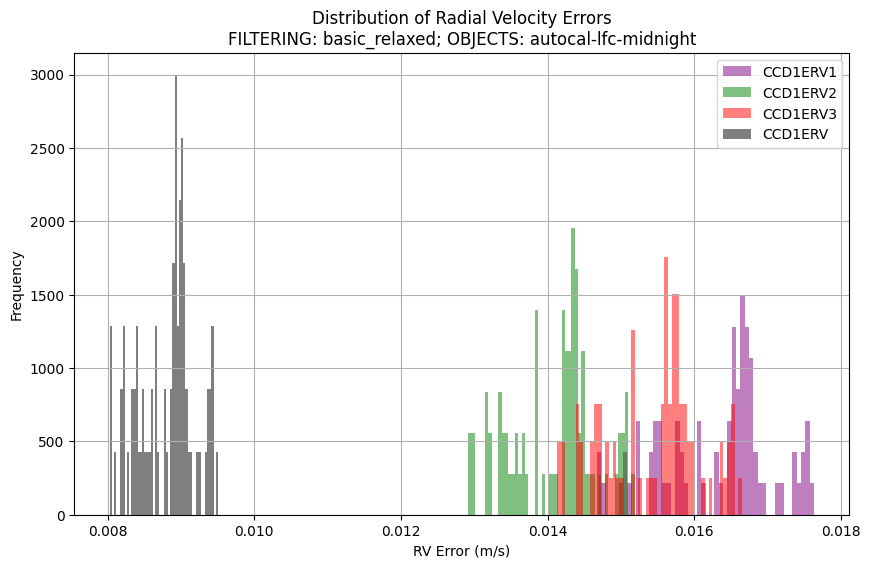

In [124]:
# pass only objects that are lfc - midnight
df_ccd1_lfc_midnight = df_ccd1_lfc[df_ccd1_lfc['OBJECT'] == 'autocal-lfc-all-midnight']
perform_standard_examination(df=df_ccd1_lfc_midnight, xmin=0.1, xmax=.35, ymin=134, ymax=139, subtitle='FILTERING: basic_relaxed; OBJECTS: autocal-lfc-midnight')

#### EDA - CCD1 - LFC - morn

DataFrame Shape: (249, 185)
['autocal-lfc-all-morn']


/tmp/ipykernel_31/1733266532.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_31/1733266532.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



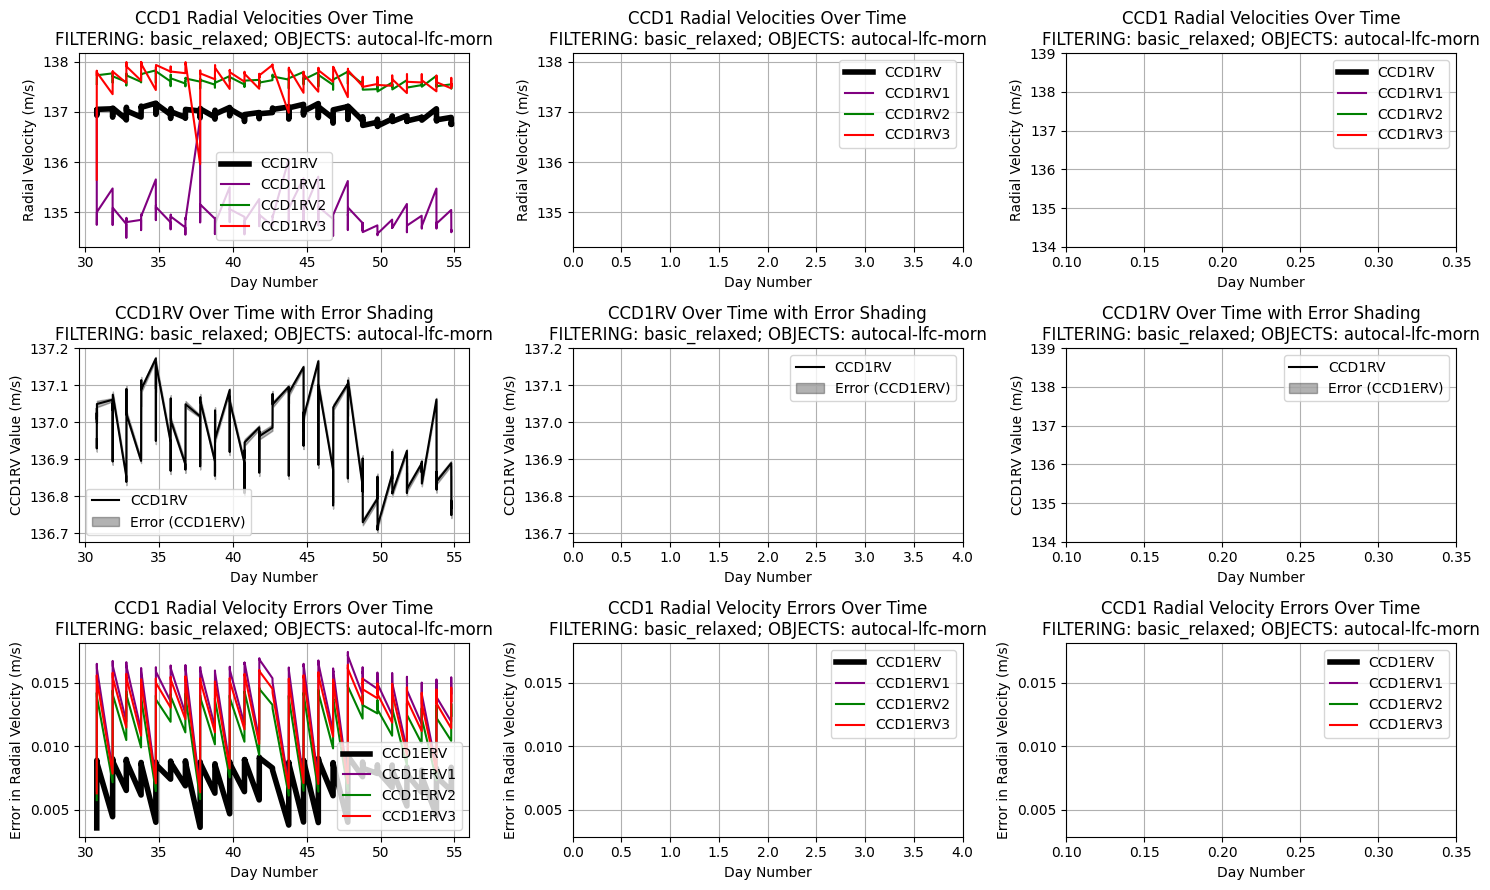

Radial Velocity Value (RV) Statistics:


Mean (m/s)  Median (m/s)  Mode (m/s)  IQR (m/s)  StDev (m/s)  \
CCD1RV   136.953825    136.956735  136.708939   0.175947     0.102272   
CCD1RV1  134.883323    134.850412  134.492079   0.246802     0.278118   
CCD1RV2  137.613170    137.611015  137.403687   0.153704     0.094084   
CCD1RV3  137.731255    137.762398  135.649815   0.179421     0.224671   

          CoV (%)  Skewness   Kurtosis  
CCD1RV   0.074676 -0.101912  -0.941374  
CCD1RV1  0.206192  3.970977  24.195688  
CCD1RV2  0.068368  0.113860  -0.844278  
CCD1RV3  0.163123 -5.395006  43.436178

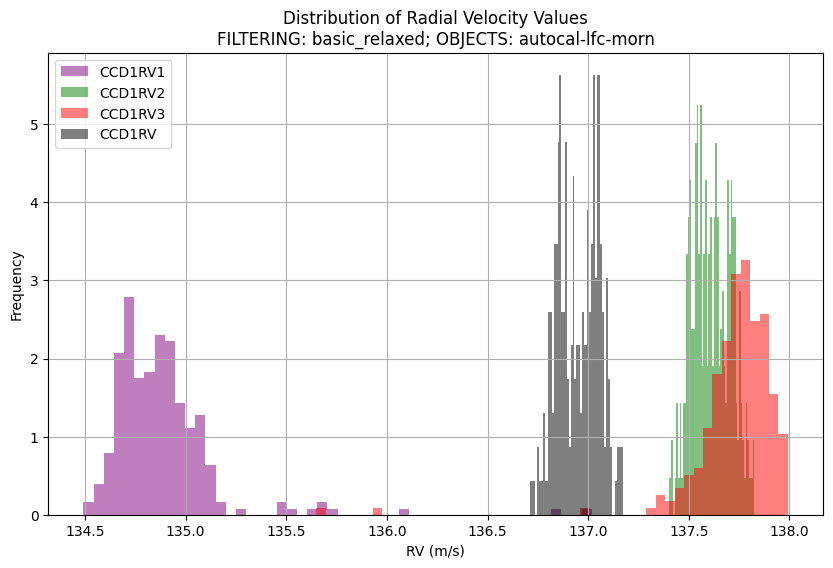

Radial Velocity Error (ERV) Statistics:


Mean (m/s)  Median (m/s)  Mode (m/s)  IQR (m/s)  StDev (m/s)  \
CCD1ERV     0.008302      0.008636    0.008412   0.000559     0.001058   
CCD1ERV1    0.015374      0.016007    0.006475   0.001071     0.001998   
CCD1ERV2    0.013285      0.013810    0.014010   0.000864     0.001673   
CCD1ERV3    0.014554      0.015131    0.006288   0.000964     0.001838   

            CoV (%)  Skewness  Kurtosis  
CCD1ERV   12.741119 -2.929196  8.726920  
CCD1ERV1  12.996086 -2.902685  8.544480  
CCD1ERV2  12.596399 -2.950975  8.864225  
CCD1ERV3  12.631450 -2.943525  8.819957

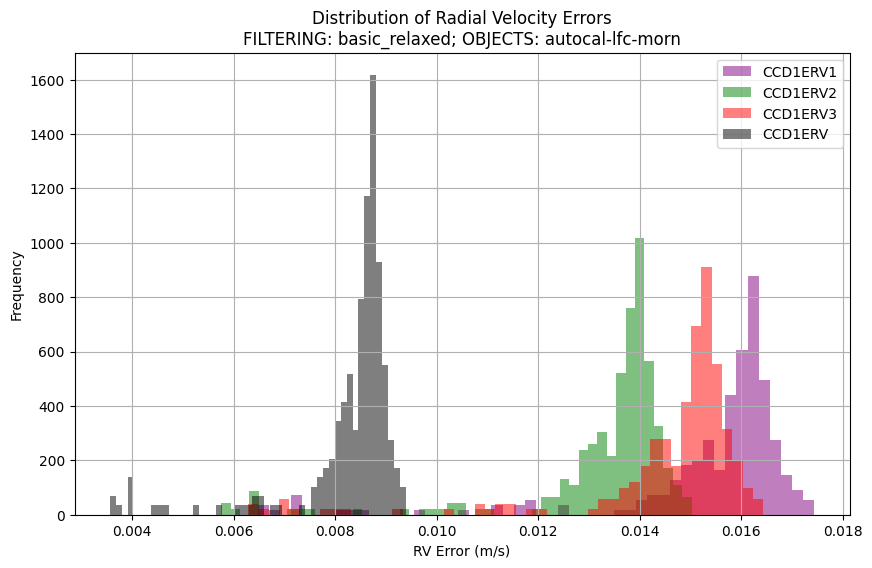

In [125]:
# pass only objects that are lfc - morn
df_ccd1_lfc_morn = df_ccd1_lfc[df_ccd1_lfc['OBJECT'] == 'autocal-lfc-all-morn']
perform_standard_examination(df=df_ccd1_lfc_morn, xmin=0.1, xmax=.35, ymin=134, ymax=139, subtitle='FILTERING: basic_relaxed; OBJECTS: autocal-lfc-morn')

# Provisional

## Folded plots (period specification)

In [126]:
print('z')

z


In [40]:
# define a function to ovrlay all cycles, over a given period, for a specified feature
def plot_time_folds(df, col_name, period=1):  # Default period set to 1 day
    # remove rows with NaN or infinite values in 'day_num' or 'col_name'
    df_clean = df.dropna(subset=['day_num', col_name])
    df_clean = df_clean[np.isfinite(df_clean['day_num']) & np.isfinite(df_clean[col_name])]
    
    # make a scatter plot of feature over time
    plt.figure(figsize=(12, 4))
    plt.scatter(df_clean['day_num'], df_clean[col_name], alpha=0.6)
    plt.title(f"Scatter Plot of {col_name} vs Day Number")
    plt.xlabel('Day Number')
    plt.ylabel(col_name)
    plt.grid(True)
    plt.show()
    
    # make a phase folded scatter plot of the feature over a given period
    # compute the phase using the specified period
    phase = (df_clean['day_num'] % period) / period
    cycles = (df_clean['day_num'] // period).astype(int)  # determine which cycle each point belongs to
    plt.figure(figsize=(12, 4))
    # make a scatter plot with each cycle in a different color
    scatter = plt.scatter(phase * period, df_clean[col_name], c=cycles, cmap='plasma', alpha=0.6)
    plt.colorbar(scatter, label='Cycle Number')
    plt.title(f"Phase-Folded Plot for Period: {period} days")
    plt.xlabel(f'Time within Period ({period} days)')
    plt.ylabel(col_name)
    plt.grid(True)
    plt.show()


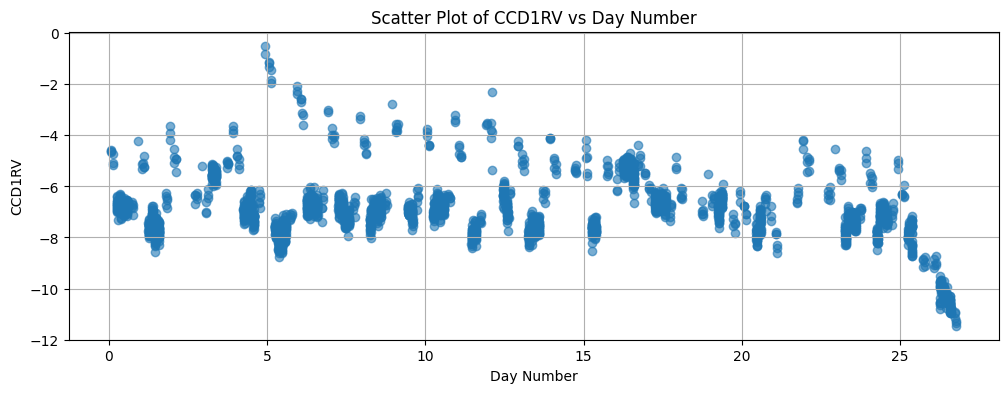

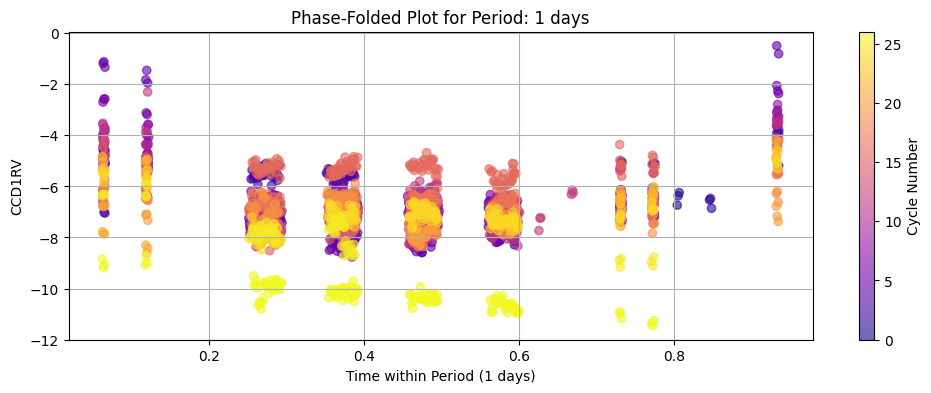

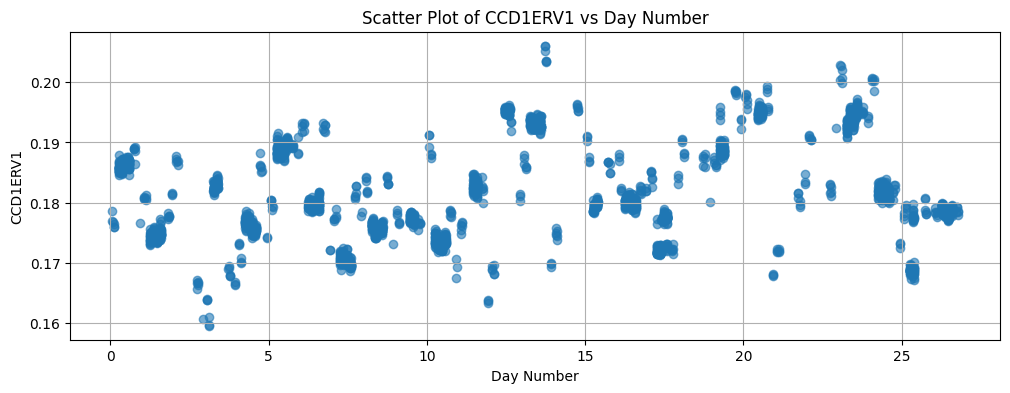

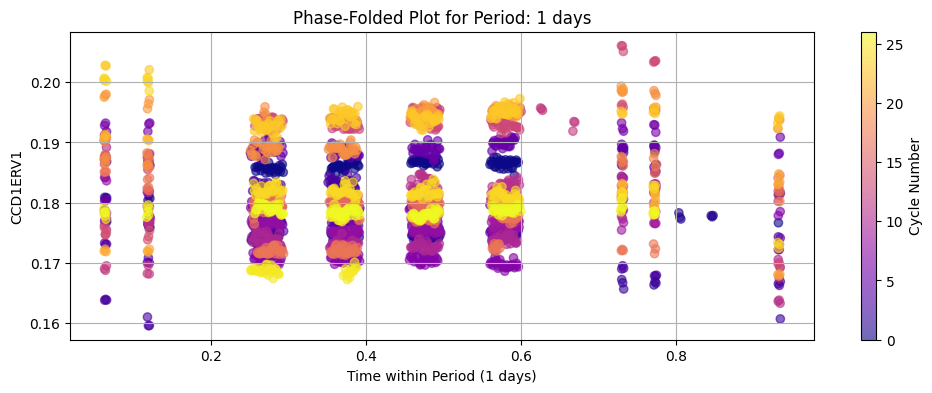

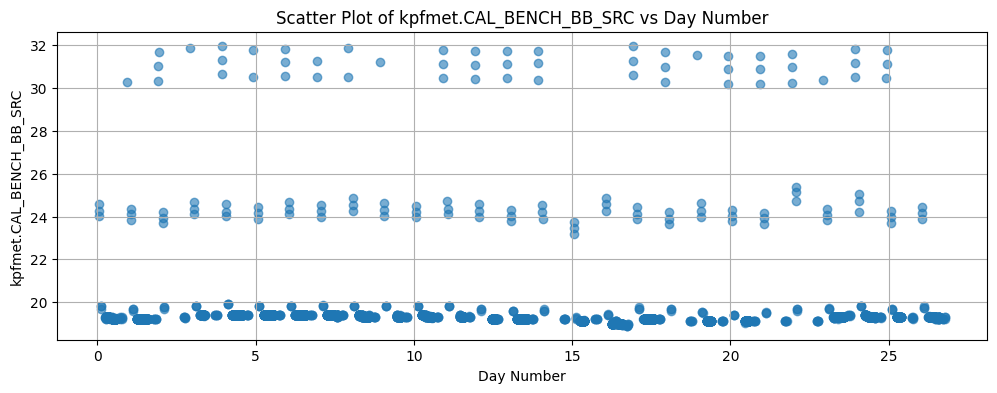

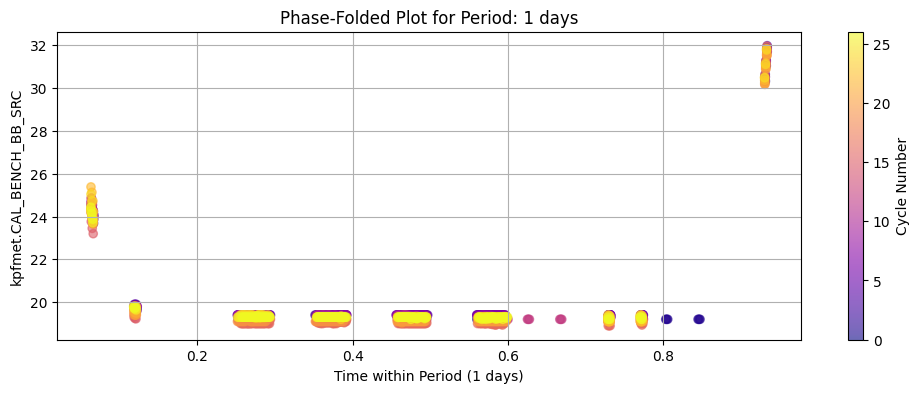

In [41]:
plot_time_folds(df_ccd1_etalon, 'CCD1RV') # kpfmet.CAL_BENCH_BB_SRC  Cal bench blackbody source temp
plot_time_folds(df_ccd1_etalon, 'CCD1ERV1') # kpfmet.CAL_BENCH_BB_SRC  Cal bench blackbody source temp
plot_time_folds(df_ccd1_etalon, 'kpfmet.CAL_BENCH_BB_SRC') # kpfmet.CAL_BENCH_BB_SRC  Cal bench blackbody source temp

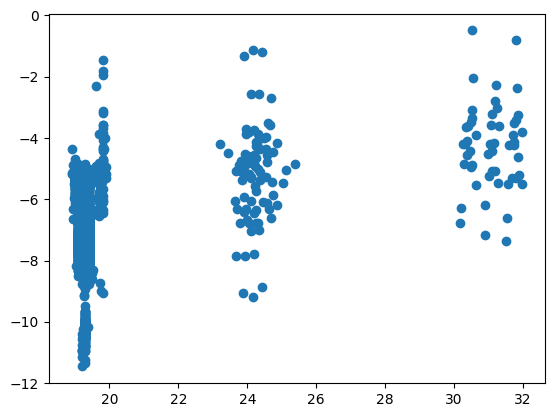

In [42]:
plt.scatter(df_ccd1_etalon['kpfmet.CAL_BENCH_BB_SRC'], df_ccd1_etalon['CCD1RV'])
plt.show()

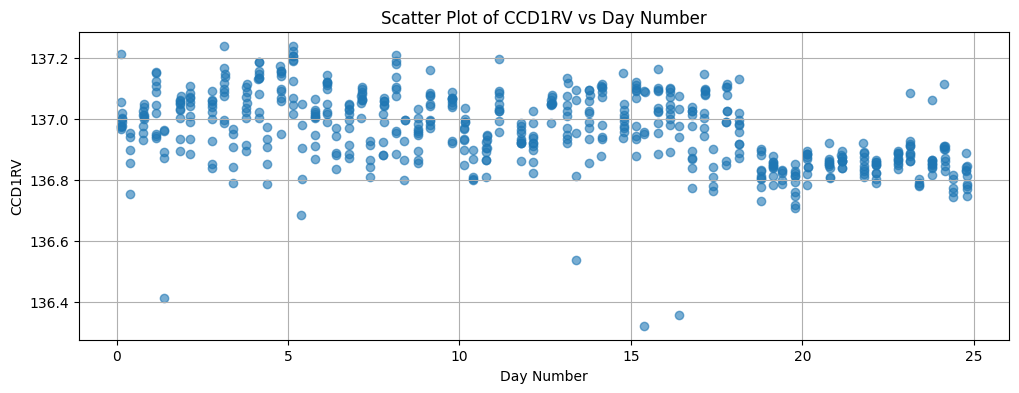

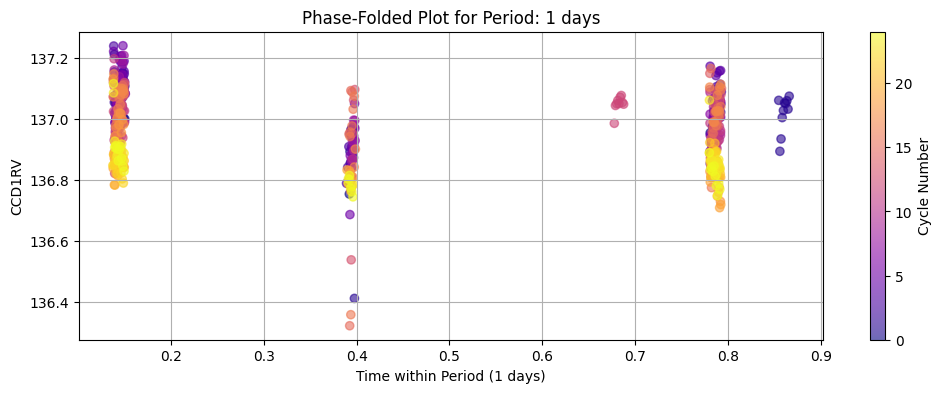

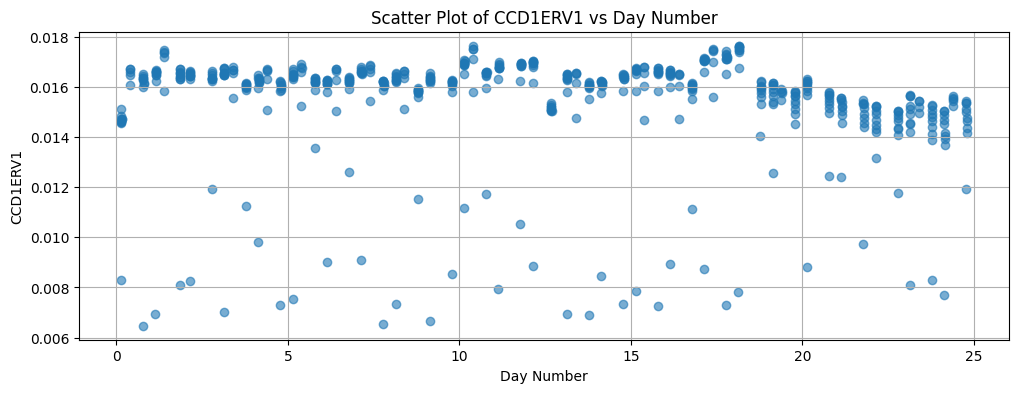

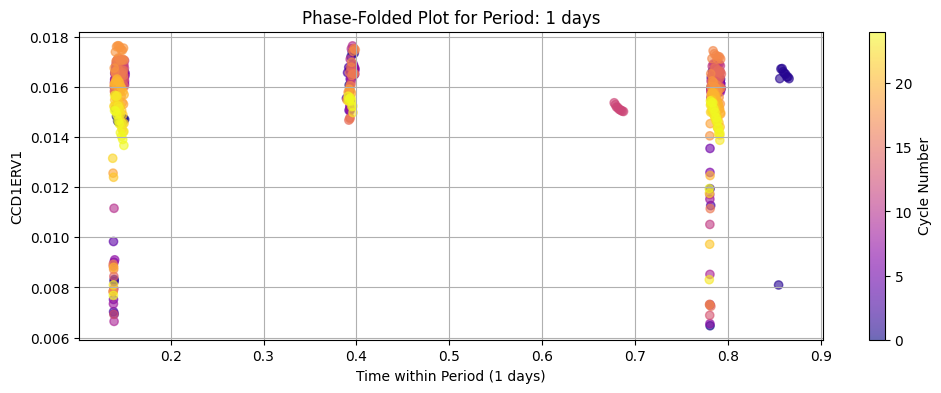

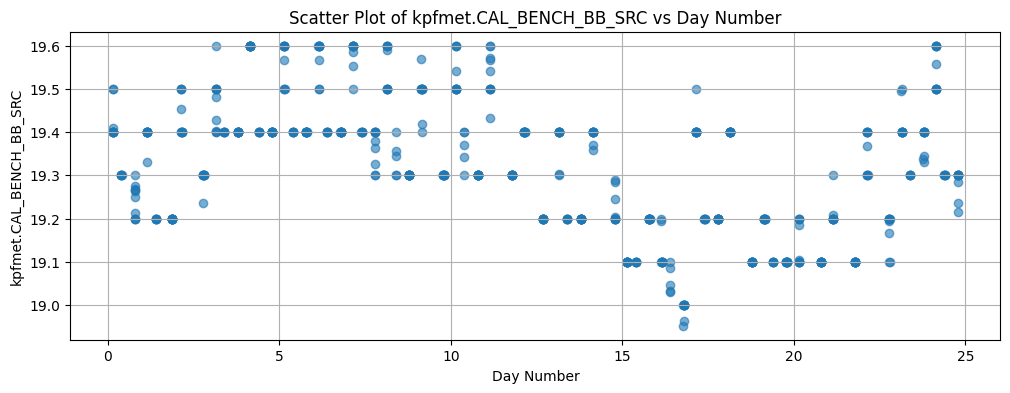

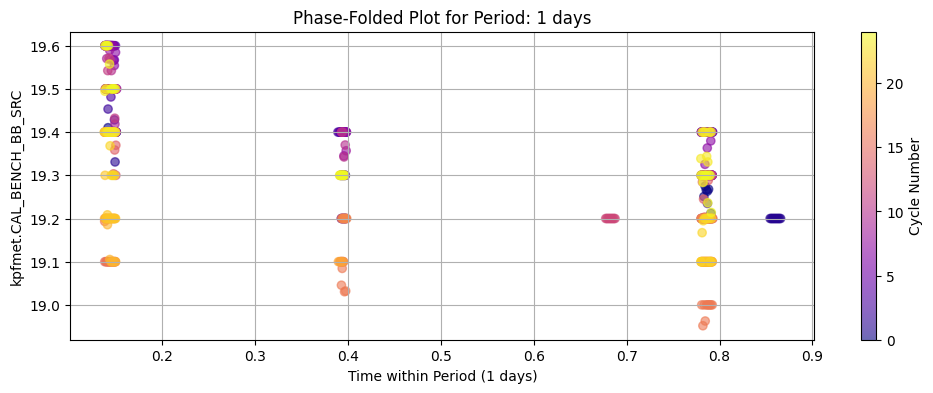

In [43]:
plot_time_folds(df_ccd1_lfc, 'CCD1RV') # kpfmet.CAL_BENCH_BB_SRC  Cal bench blackbody source temp
plot_time_folds(df_ccd1_lfc, 'CCD1ERV1') # kpfmet.CAL_BENCH_BB_SRC  Cal bench blackbody source temp
plot_time_folds(df_ccd1_lfc, 'kpfmet.CAL_BENCH_BB_SRC') # kpfmet.CAL_BENCH_BB_SRC  Cal bench blackbody source temp

## Folded plots (period decomposition)

In [44]:
from scipy.signal import periodogram

# define a function to ovrlay all cycles, over the highest-power periods, for a specified feature
def plot_time_decomposition(df, col_name):

    # data cleaning: need to drop rows where 'day_num' or 'col_name' is NaN or infinite
    df = df.dropna(subset=['day_num', col_name])
    df = df[np.isfinite(df['day_num']) & np.isfinite(df[col_name])]

    # make a scatter plot of feature over time
    plt.figure(figsize=(12, 4))
    plt.scatter(df['day_num'], df[col_name], alpha=0.6)
    plt.title(f"Scatter Plot of {col_name} vs Day Number")
    plt.xlabel('Day Number')
    plt.ylabel(col_name)
    plt.grid(True)
    plt.show()

    # apply fourier analysis, generate a periodogram, and annotate top-3 peaks
    fs = 1 / (df['day_num'].diff().median())  # compute sampling frequency in cycles/day
    frequencies, powers = periodogram(df[col_name], fs=fs)
    plt.figure(figsize=(12, 4))
    plt.semilogy(frequencies, powers)
    plt.title('Fourier Transform')
    plt.xlabel('Frequency (cycles/day)')
    plt.ylabel('Power')
    plt.xlim(0,100)
    # highlight the top 3 peaks
    top_freqs = frequencies[np.argsort(powers)[-3:]]
    for freq in top_freqs:
        plt.annotate(f'{freq:.4f}', xy=(freq, max(powers)), arrowprops=dict(arrowstyle='->'))
    plt.grid(True)
    plt.show()

    # make the pase-folded plots for top-3 frequencies
    for freq in top_freqs:
        period = 1 / freq
        phase = (df['day_num'] % period) / period
        cycles = (df['day_num'] // period).astype(int)  # determine which cycle each point belongs to
        plt.figure(figsize=(12, 4))
        scatter = plt.scatter(phase * period, df[col_name], c=cycles, cmap='viridis', alpha=0.6)  # using colormap 'viridis'
        plt.colorbar(scatter, label='Cycle Number')
        plt.title(f'Phase Folded Plot at Period: {period:.4f} days')
        plt.xlabel('Phase [days]')
        plt.ylabel(col_name)
        plt.grid(True)
        plt.show()

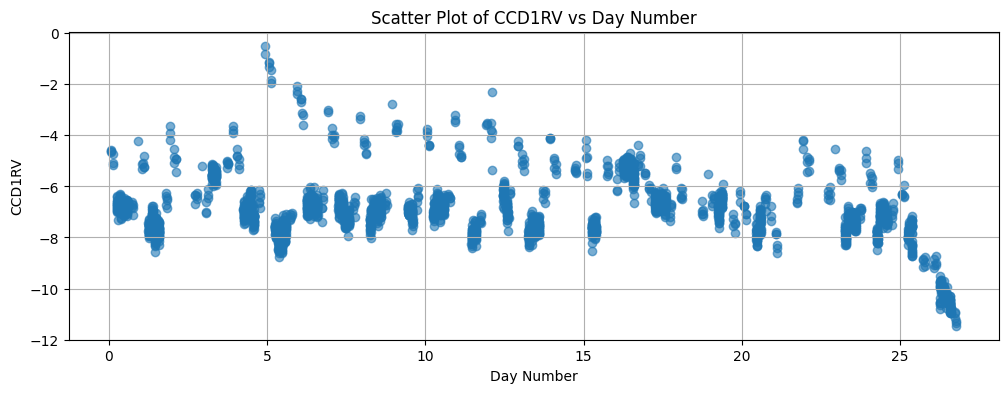

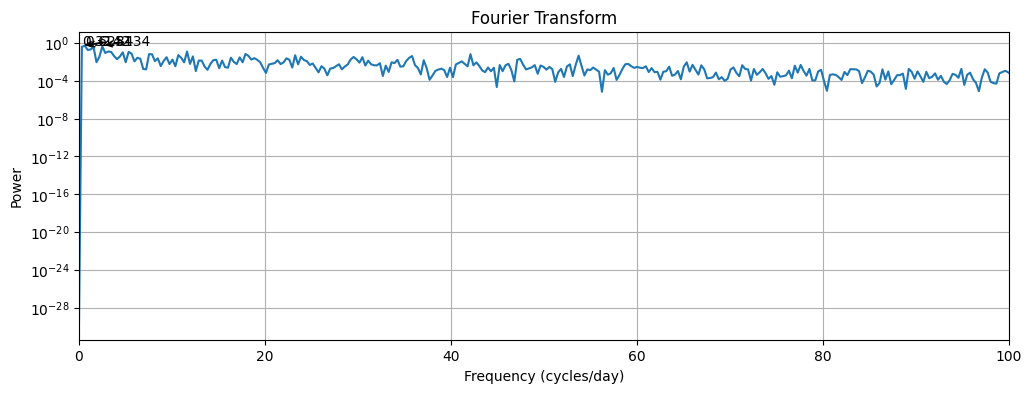

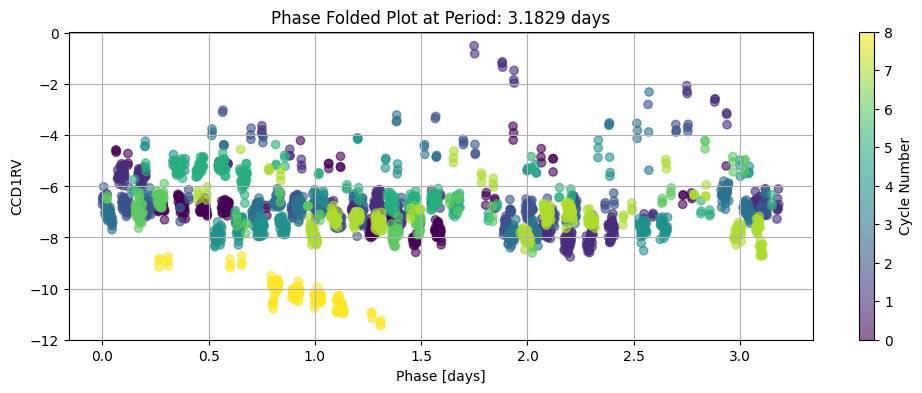

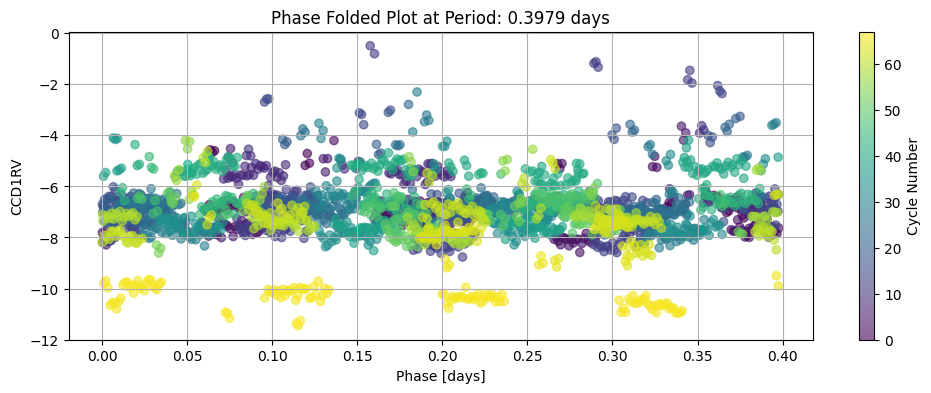

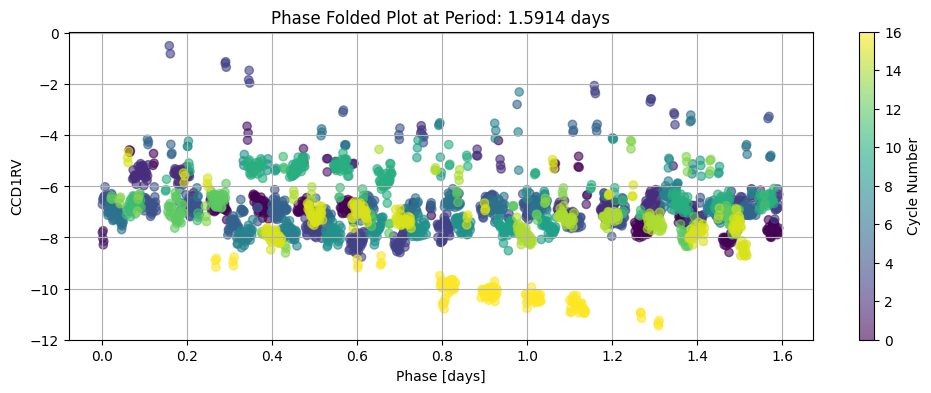

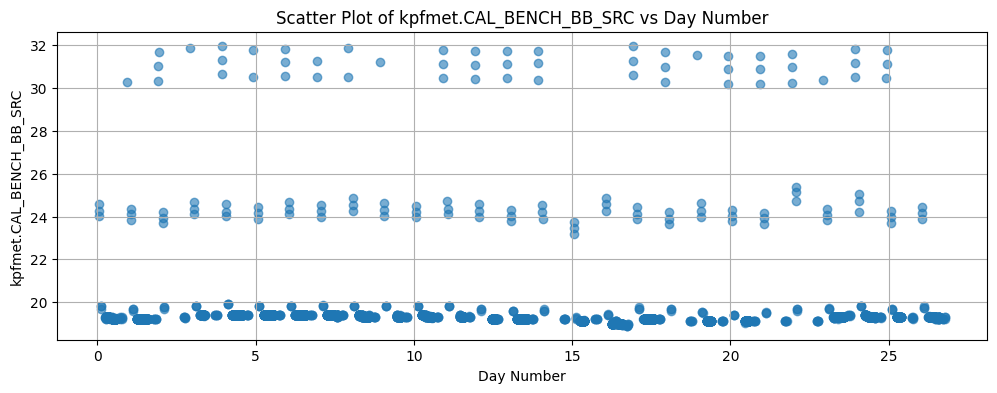

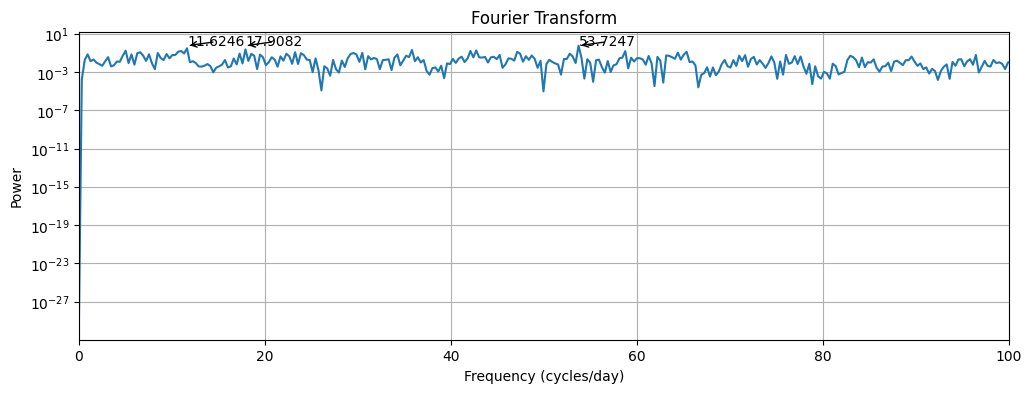

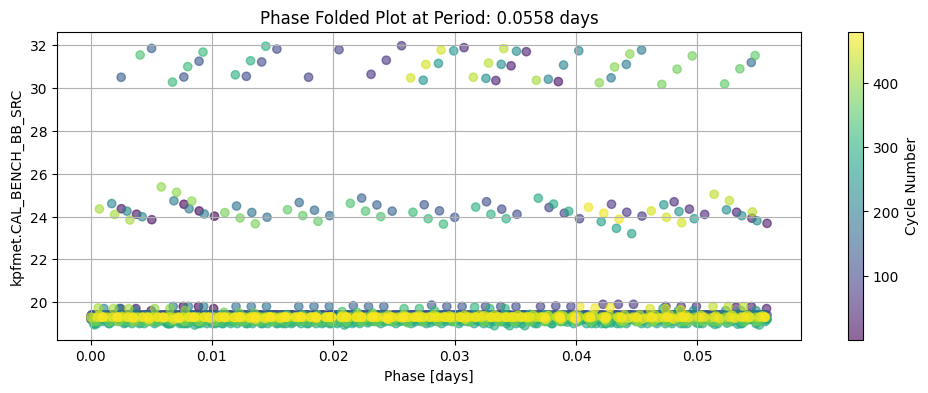

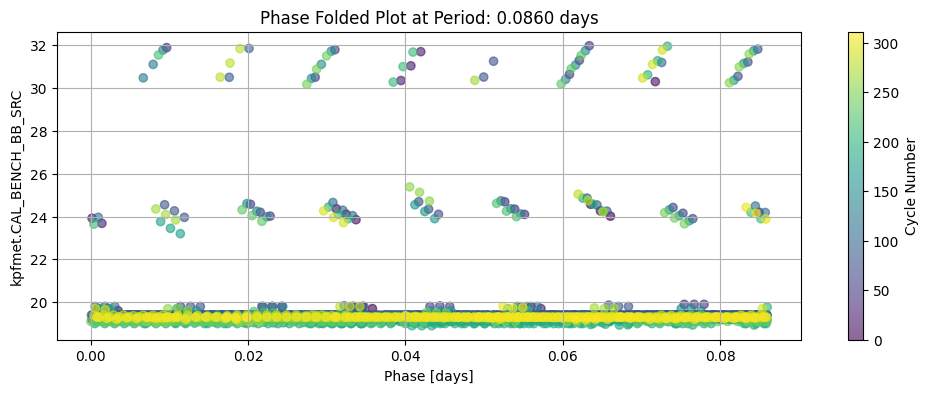

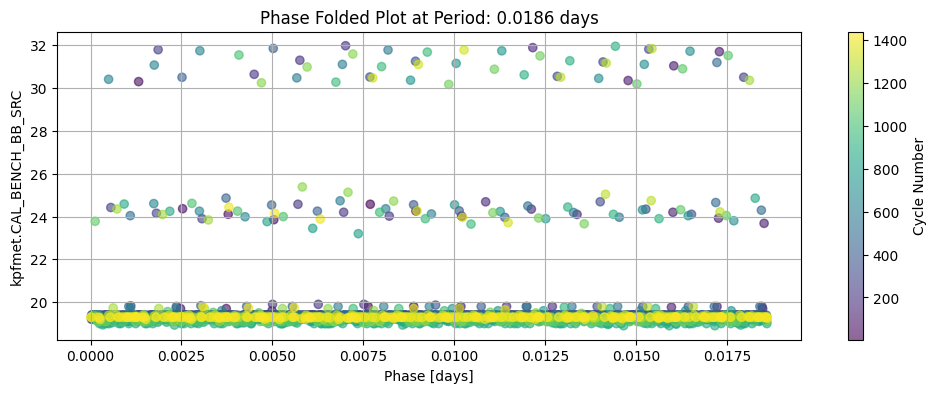

In [45]:
plot_time_decomposition(df_ccd1_etalon, 'CCD1RV') # kpfmet.CAL_BENCH_BB_SRC  Cal bench blackbody source temp
plot_time_decomposition(df_ccd1_etalon, 'kpfmet.CAL_BENCH_BB_SRC') # kpfmet.CAL_BENCH_BB_SRC  Cal bench blackbody source temp

## RV values vs. RV Errors for a given Fiber, by time of day

In [46]:
# make a scatter plot of RV values and RV errors for each object in CCD1 using Plotly
def plot_rv_error_scatter_by_object(df, ubtitle='unspecified details', hover_details=['ObsID', 'OBJECT', 'day_num']):
    fig = go.Figure()

    # Ffilter the df's for different objects
    df_eve = df[df['OBJECT'] == 'autocal-lfc-all-eve']
    df_midnight = df[df['OBJECT'] == 'autocal-lfc-all-midnight']
    df_morn = df[df['OBJECT'] == 'autocal-lfc-all-morn']

    # Data configuration for each object
    object_config = [
        (df_eve, 'blue', 'Evening'),
        (df_midnight, 'orange', 'Midnight'),
        (df_morn, 'green', 'Morning')
    ]

    # make a plot for each object with hover data
    for object_df, color, name in object_config:
        rv_col = 'CCD1RV1'
        rv_err_col = 'CCD1ERV1'
        fig.add_trace(go.Scatter(
            x=object_df[rv_col],
            y=object_df[rv_err_col],
            mode='markers',
            marker=dict(color=color),
            name=name,
            text=object_df[hover_details].astype(str).agg(', '.join, axis=1),
            hoverinfo='text+x+y'
        ))

    # update the layout to set the axis limits and labels
    fig.update_layout(
        title='Correlation Between CCD1 Fiber 1 Radial Velocity Values and Errors, by Time of Day' + subtitle,
        xaxis=dict(title='RV (km/s)'),
        yaxis=dict(title='Error in RV (m/s)'),
        legend_title="Measurement times",
        hovermode='closest'
    )

    fig.show()

In [47]:
plot_rv_error_scatter_by_object(df_ccd1_lfc, subtitle=': LFC')

TypeError: plot_rv_error_scatter_by_object() got an unexpected keyword argument 'subtitle'

In [ ]:
# show the 5 lowest values for CCD1RV1 in the night
display(df_ccd1_lfc_midnight.sort_values(by='CCD1RV1', ascending=False).tail(5)[['ObsID', 'CCD1RV1']])

# show the 5 highest values for CCD1RV1 in the eve
display(df_ccd1_lfc_eve.sort_values(by='CCD1RV1', ascending=False).head(5)[['ObsID', 'CCD1RV1']])

ObsID     CCD1RV1
27279  KP.20241017.34064.59  134.228970
26747  KP.20241016.34172.78  134.115105
711    KP.20240902.34172.46  133.449646
712    KP.20240902.34280.92  132.748567
713    KP.20240902.34389.23  132.039043

ObsID     CCD1RV1
8272  KP.20240917.12887.47  135.399649
8273  KP.20240917.12995.88  135.382434
8267  KP.20240917.12344.67  135.328654
8271  KP.20240917.12779.08  135.323710
8269  KP.20240917.12561.97  135.316197

## Colinearity Examination

In [ ]:
!pip install statsmodels
!pip install seaborn
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 125.0 kB/s eta 0:00:0000:020:04m


In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# define a function to prepare the data for colinearity analysis
def clean_data(df, target_col):
    # segregate the target column
    target_data = df[[target_column]]  # preserve target separately
    df_features = df.drop(columns=[target_column])  # work with other features
    # remove non-numeric columns from features
    df_numeric = df_features.select_dtypes(include=[np.number])
    # remove columns with constant values or all NaNs from features
    df_numeric = df_numeric.loc[:, (df_numeric.nunique() > 1) & (df_numeric.isna().mean() < 1)]
    df_clean = df_numeric.dropna()
    return df_clean

# define a function to standardize the feature values
def scale_features(dataframe, target_column):
    features = dataframe.drop(columns=[target_column])
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
    
    # Add the target column back to the scaled dataframe
    scaled_df[target_column] = dataframe[target_column].values
    return scaled_df

# define a function to remove (nearly)-constant features, which are necessarily irrelavant
def remove_low_variance_features(dataframe, target_column, threshold=0.01):
    # separate target to ensure it's not affected by variance thresholding
    target_data = dataframe[[target_column]]
    features = dataframe.drop(columns=[target_column])
    
    # calculate variance for each column
    variances = features.var()
    # filter columns to remove those with variance below the threshold
    high_variance_columns = variances[variances > threshold].index.tolist()
    filtered_dataframe = features[high_variance_columns]

    # re-add the target column
    filtered_dataframe = pd.concat([filtered_dataframe, target_data], axis=1)
    return filtered_dataframe

# define a function to identify and remove highly correlated features based on correlation matrix
# NOTE: the advantage of the correlation matrix over the covariance matrix is that correlation matrix standardizes the Covariance by the product of the stdev's, providing a normalized measure of linear dependence [-1,1]
def remove_highly_correlated_features(dataframe, target_column, threshold=0.95):
    # separate target to ensure it's not affected by correlation thresholding
    target_data = dataframe[[target_column]]
    features = dataframe.drop(columns=[target_column])
    
    # compute the correlation matrix
    corr_matrix = features.corr().abs() # Take the absolute value of correlation coefficients
    # identify the features that are highly correlated
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # drop features
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    reduced_dataframe = features.drop(columns=to_drop)
    
    # re-add the target column
    reduced_dataframe = pd.concat([reduced_dataframe, target_data], axis=1)
    return reduced_dataframe, to_drop

"""
# define a function to compute the covariance matrix
# NOTE: this provides insight into how two features linearly vary togther, but not in combination with other features varying with some target
def compute_covariance_matrix(dataframe):
    return dataframe.cov()

sns.heatmap(covariance_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Covariance Matrix Heatmap')
plt.show()"""

# define a function to check for colinearity using variance inflation factor (VIF), which is an index that measures how much the variance of an estimated regression coefficient is increased b/c of colinearity
# NOTE: the advantage of VIF over pairwise correlations from the covariance matrix, is that VIF is scale-independent, making it more suitable for multicollinearity analysis
# NOTE: a VIF of 1 indicates no correlation between a feature and any other features; a VIF exceeding 10 suggests high multicollinearity
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# define a function to filter out features w/ a VIF greater than some threshhold
def filter_non_collinear_features(vif_data, threshold=5.0):
    non_collinear_features = vif_data[vif_data['VIF'] < threshold]['feature'].tolist()
    return non_collinear_features

# define a function to compute the correlation matrix and extract the correlation 
def analyze_correlation(dataframe, target_column):
    correlation_matrix = dataframe.corr()
    target_correlation = correlation_matrix[[target_column]].sort_values(by=target_column, key=abs, ascending=False)
    return target_correlation


In [ ]:
# specify data for analysis
df_initial = df_ccd1_etalon
target_column = 'CCD1ERV'

# exclude columns from analysis
df_initial = df_initial.drop(columns=['CCFRV', 'CCFERV',                                        # final RV data from CCD1 & CCD1 (2 cameras)
    'CCD1RV', #'CCD1ERV',                                                                        # mean RV data from CCD1 (3 science fibers) 
    'CCD1RV1', 'CCD1ERV1', 'CCD1RV2', 'CCD1ERV2', 'CCD1RV3', 'CCD1ERV3',                                # RV data from the 3 science fibers
    'CCD1RVC',                                                                                # RV data from calibration fiber (MISSING ERROR?)
    'CCD1RVS', 'CCD1ERVS',                                                                      # RV data from sky fiber
    "CAL-OBJ", "SKY-OBJ", "SCI-OBJ",                                                        # fiber sources
    'ETAV1C1T', 'ETAV1C2T', 'ETAV1C3T', 'ETAV1C4T', 'ETAV2C3T',                                       # etalon assembly temperatures
    'SNRSC452', 'SNRSC548', 'SNRSC652', 'SNRSC747', 'SNRSC852',                                       # SNR for science fibers
    'SNRCL452', 'SNRCL548', 'SNRCL652', 'SNRCL747', 'SNRCL852',                                       # SNR for calibration fiber
    'SNRSK452', 'SNRSK548', 'SNRSK652', 'SNRSK747', 'SNRSK852'])    

# load and clean data
df_cleaned = load_and_clean_data(df_initial, target_column)

df_scaled = scale_features(df_cleaned, target_column)

# remove low-variance features while keeping the target column safe
df_variations = remove_low_variance_features(df_scaled, target_column)

# remove highly correlated features while keeping the target column safe
df_reduced, dropped_features = remove_highly_correlated_features(df_variations, target_column)
print("\nDropped features due to high correlation:", dropped_features)

# calculate VIF, ensuring target column is not included
if target_column in df_reduced.columns:
    df_for_vif = df_reduced.drop(columns=[target_column])
    vif_df = calculate_vif(df_for_vif)
    print("\nVIF Results:", vif_df)

# analyze correlation, ensuring target column is present
correlation_results = analyze_correlation(df_reduced, target_column)
print("\nCorrelation Results:", correlation_results)




Dropped features due to high correlation: ['day_num', 'kpfmet.BENCH_BOTTOM_COLLIMATOR', 'kpfmet.BENCH_BOTTOM_DCUT', 'kpfmet.BENCH_BOTTOM_ECHELLE', 'kpfmet.BENCH_TOP_BETWEEN_CAMERAS', 'kpfmet.BENCH_TOP_COLL', 'kpfmet.BENCH_TOP_DCUT', 'kpfmet.BENCH_TOP_ECHELLE_CAM', 'kpfmet.CALEM_SCMBLR_FIBER_END', 'kpfmet.CRYOSTAT_G3', 'kpfmet.CRYOSTAT_R1', 'kpfmet.CRYOSTAT_R3', 'kpfmet.ECHELLE_BOTTOM', 'kpfmet.ECHELLE_TOP', 'kpfmet.GREEN_CAMERA_BOTTOM', 'kpfmet.GREEN_CAMERA_COLLIMATOR', 'kpfmet.GREEN_CAMERA_ECHELLE', 'kpfmet.GREEN_CAMERA_TOP', 'kpfmet.GREEN_GRISM_TOP', 'kpfmet.PRIMARY_COLLIMATOR_TOP', 'kpfmet.RED_CAMERA_BOTTOM', 'kpfmet.RED_CAMERA_COLLIMATOR', 'kpfmet.RED_CAMERA_ECHELLE', 'kpfmet.RED_CAMERA_TOP', 'kpfmet.RED_GRISM_TOP', 'kpfmet.REFORMATTER', 'kpfmet.SCIENCE_CAL_FIBER_STG', 'kpfmet.SIMCAL_FIBER_STG', 'kpfmet.U_GOLD', 'kpfgreen.BRD10_DRVR_T', 'kpfgreen.BRD11_DRVR_T', 'kpfgreen.BRD12_LVXBIAS_T', 'kpfgreen.BRD1_HTRX_T', 'kpfgreen.BRD3_LVDS_T', 'kpfgreen.BRD4_DRVR_T', 'kpfgreen.BRD5_AD_T',

## Ongoing Development

In [ ]:
print('testerX')

s


# Follow-ups

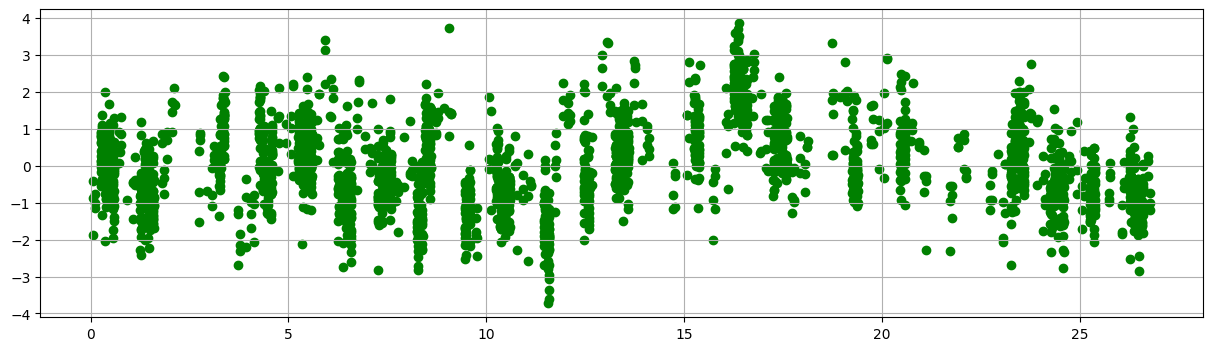

In [ ]:
plt.figure(figsize=(15, 4)); plt.grid(True)
plt.scatter(df_ccd1_etalon['day_num'],
            (df_ccd1_etalon['CCD1RV']-df_ccd1_etalon['CCD1RVC'])
            + 6.5, # where does this offset come from?  NOTE: take a look at the RV value histogram!
            color='green')
plt.show()

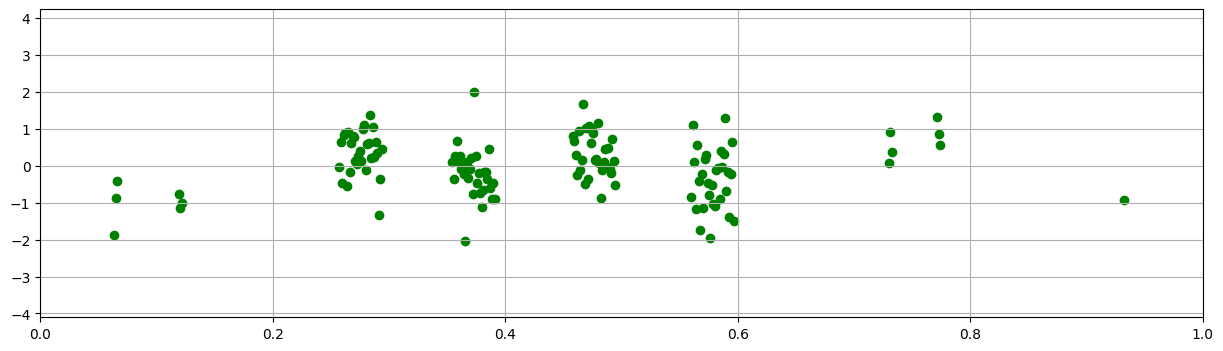

In [ ]:
plt.figure(figsize=(15, 4)); plt.grid(True)
plt.scatter(df_ccd1_etalon['day_num'],
            (df_ccd1_etalon['CCD1RV']-df_ccd1_etalon['CCD1RVC'])
            + 6.5, # where does this offset come from?
            color='green')
plt.xlim(0,1)
plt.show()

# NOTE: one set of observations should have 0.1 m/s scatter (or RMS)
#       (which we know based on the observed internal precision, such as the ERV historgrams),
#       but it's actually much higher, ~ 2m/s! why?

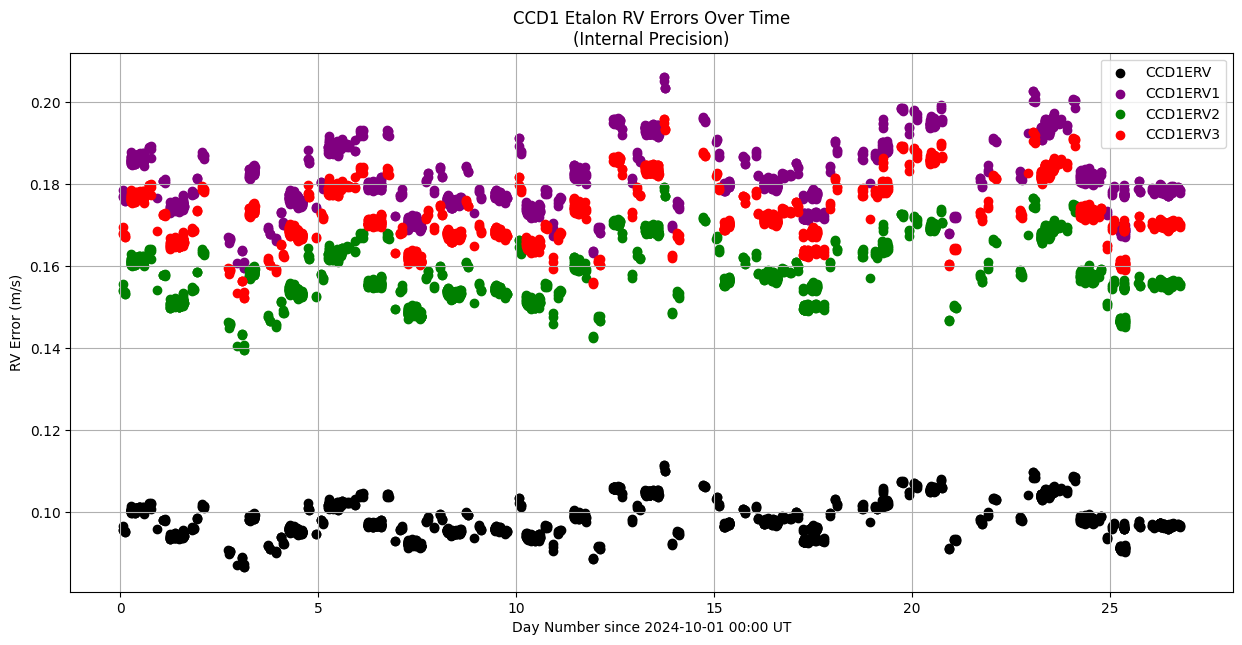

In [156]:
df = df_ccd1_etalon

# make figure and axes grid
fig, axs = plt.subplots(figsize=(15, 7))  # Only one plot, axs is a single Axes object
axs.scatter(df['day_num'], df['CCD1ERV'], label='CCD1ERV', color='black')
axs.scatter(df['day_num'], df['CCD1ERV1'], label='CCD1ERV1', color='purple')
axs.scatter(df['day_num'], df['CCD1ERV2'], label='CCD1ERV2', color='green')
axs.scatter(df['day_num'], df['CCD1ERV3'], label='CCD1ERV3', color='red')
axs.set_xlabel('Day Number since 2024-10-01 00:00 UT')
axs.set_ylabel('RV Error (m/s)')
axs.set_title('CCD1 Etalon RV Errors Over Time' + '\n(Internal Precision)')
axs.legend()
axs.grid(True)

plt.show()

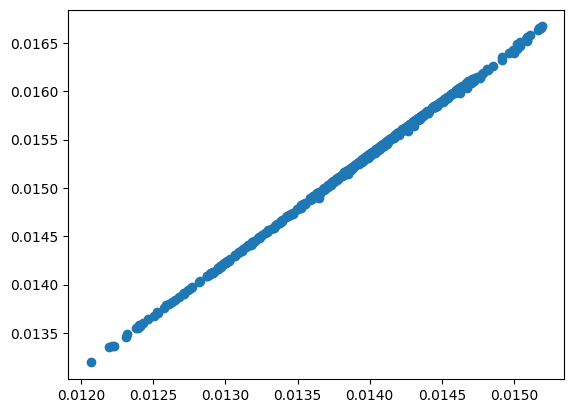

In [107]:
# plot the fiber errors against each other

plt.scatter(df_ccd1_lfc['CCD1ERV2'], df_ccd1_lfc['CCD1ERV3'])
plt.show()